# Audio key estimation of digital music with CNNs
Udacity Machine Learning Nanodegree - Capstone project

---

## Table of Contents

The project is structured as stated in section 'Project Design' of the Capstone project proposal.

_
<pre>
<a href='#Data-Preprocessing'>Data Preprocessing</a>
  <a href='#Million-Song-Dataset'>Million Song Dataset</a> - selection of appropriate songs, separate jupyter notebook
  <a href='#Signal-Processing-and-Feature-Extraction'>Signal Processing and Feature Extraction</a> - separate jupyter notebook

<a href='#Model-Preparation'>Model Preparation</a>
  <a href='#Load-and-preprocess-data'>Load and preprocess data</a> - read spectrogram images, conversion to tensors
  <a href='#Split-data-into-train-and-test-set'>Splitting data into training/testing sets</a>
  <a href='#Model-architecture'>CNN model architecture</a>
  <a href='#Model-parameter'>CNN model parameter</a>

<a href='#Model-Training-and-Evaluation'>Model Training and Evaluation</a>
  <a href='#Model-training'>Model training</a>
  <a href='#Model-evaluation-and-comparison'>Model evaluation and comparison</a>
</pre>

Current version of the project is working, but

the project is still ongoing...

discussion and remarks of what to do can be found in section

<a href='#reasons-/-todo'>reasons / todo</a>

## Data Preprocessing
---

### Million Song Dataset
- utilized to select appropriate song samples
- holds information about key and mode per song (targets)

Juypter Notebook <a href='./00.hlp/msd/msd.ipynb'>msd</a>

outputs: csv file *songs_conf=75_tracks_filt.csv*, which holds all songs with key confidence and mode confidence > 0.75

In [1]:
# LIST SELECTED SONGS
import os
import pandas as pd
from IPython.display import display

selsongsfile = os.path.join ('00.hlp', 'msd', 'songs_conf=75_tracks_filt.csv')
selsongs = pd.read_csv (selsongsfile, header=0, index_col=0)
display (selsongs.head (1))
print ('[i] number of records:', len (selsongs))

,key,key_confidence,mode,mode_confidence,tempo,track_id,song_id,artist_name,song_title
0,7,0.896,1,0.852,114.493,TRMMMGL128F92FD6AB,SOHSSPG12A8C144BE0,Clifford T. Ward,Mad About You


[i] number of records: 47913


In [2]:
# LOAD AUDIO DATASET
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_audio')
load_content = False
description = ['key C, mode minor', 'key C, mode major',
               'key C#, mode minor', 'key C#, mode major',
               'key D, mode minor', 'key D, mode major',
               'key D#, mode minor', 'key D#, mode major',
               'key E, mode minor', 'key E, mode major',
               'key F, mode minor', 'key F, mode major',
               'key F#, mode minor', 'key F#, mode major',
               'key G, mode minor', 'key G, mode major',
               'key G#, mode minor', 'key G#, mode major',
               'key A, mode minor', 'key A, mode major',
               'key A#, mode minor', 'key A#, mode major',
               'key B, mode minor', 'key B, mode major']

src_audio_data = datasets.load_files (container_path=container_path,
                                      description=description,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

In [3]:
# FYI: LIST SOME OF THE USED SONGS
filenames = list (os.path.basename (filepath) for filepath in src_audio_data['filenames'])
usedsongs_track_id = list (os.path.splitext (fn)[0] for fn in filenames)
usedsongs = selsongs.query ('track_id in @usedsongs_track_id')

display (usedsongs.sample(5))
print ('[i] number of records:', len (usedsongs))
print ('[i] min of: key_confidence =', usedsongs['key_confidence'].min (), ',', \
       'mode_confidence =', usedsongs['mode_confidence'].min ())
print ('[i] tempo: min =', usedsongs['tempo'].min (), ',', \
       'max =', usedsongs['tempo'].max ())

,key,key_confidence,mode,mode_confidence,tempo,track_id,song_id,artist_name,song_title
9446,3,1.0,1,0.902,168.906,TRRRPKJ128F146AFD4,SOXGRHH12A58A7D67E,Hot Chocolate,You'll Always Be A Friend
32233,10,1.0,0,0.884,149.973,TRENOSF128F14552A5,SOIYDYW12A6D4F6F20,Eminem,When I'm Gone
27745,8,1.0,1,1.000,127.951,TRUGCKB128F425AC16,SODHLDK12A8C136CFD,Jeff And Sheri Easter,Forever And A Day
7510,8,1.0,1,1.000,113.208,TRCHSTZ12903CAAAB9,SOLPFMY12A58A7B830,Brian Hyland,Just Knowing You Is A Pleasure
10070,0,1.0,0,0.849,112.893,TRRTCMY128F9326B32,SOYGPIR12AB018646A,The Levon Helm Band,A Fool In Love


[i] number of records: 240
[i] min of: key_confidence = 0.809 , mode_confidence = 0.777
[i] tempo: min = 0.0 , max = 248.32299999999998


In [4]:
# ----- save list of used songs
usedsongs.to_csv ('usedsongs.csv')

In [7]:
# ----- save list of unused songs
unusedsongs = selsongs.drop ((usedsongs.index.values))
unusedsongs.to_csv ('unusedsongs.csv')

### Signal Processing and Feature Extraction
- create spectrograms of audio files with discrete Fourier transform (DFT)
- save spectrograms as images for further use in CNN

Juypter Notebook <a href='./00.hlp/fft/fft.ipynb'>fft</a>

ouptuts: spectrograms (png images) of audio files with same folder structure as *src_audio* in new container path named *src_spectro*

**Example of a spectrogram image**

<img src ='./src_spectro/7-0/TREDRTV12903D03829.png' align=left>

## Model Preparation
---

### Load and preprocess data

### Data Preprocessing
Since there aren't enough samples to proper train the classifier, image augmentation is used.

Below jupyter notebook does the work.

Juypter Notebook <a href='./00.hlp/trnsp/trnsp.ipynb'>transposing songs</a>

In [26]:
# LOAD SPECTROGRAM FILENAMES
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_spectro')
load_content = False
description = ['key C, mode minor', 'key C, mode major',
               'key C#, mode minor', 'key C#, mode major',
               'key D, mode minor', 'key D, mode major',
               'key D#, mode minor', 'key D#, mode major',
               'key E, mode minor', 'key E, mode major',
               'key F, mode minor', 'key F, mode major',
               'key F#, mode minor', 'key F#, mode major',
               'key G, mode minor', 'key G, mode major',
               'key G#, mode minor', 'key G#, mode major',
               'key A, mode minor', 'key A, mode major',
               'key A#, mode minor', 'key A#, mode major',
               'key B, mode minor', 'key B, mode major']

src_spectro_data = datasets.load_files (container_path=container_path,
                                        description=description,
                                        load_content=load_content,
                                        random_state=PARAM_RND_STATE)
src_spectro_data.keys ()

dict_keys(['DESCR', 'filenames', 'target', 'target_names'])

In [27]:
print ('[i] example of loaded spectrogram file data:')
print ('    spectrogram image name:', src_spectro_data['filenames'][0])
print ('    spectrogram image key-mode pair:',\
       src_spectro_data['target_names'][src_spectro_data['target'][0]],\
       '=', src_spectro_data['DESCR'][src_spectro_data['target'][0]],\
       '= target class', src_spectro_data['target'][0])

[i] example of loaded spectrogram file data:
    spectrogram image name: src_spectro/9-0/TRINRNG128F93539C0_1-oct.png
    spectrogram image key-mode pair: 9-0 = key B, mode minor = target class 22


**Read in images, convert to tensors**

Keras Conv2D layers expect a **4D tensor with shape (batch, rows, cols, channels)** (if param data_format='channels_last') (src: <a href='https://keras.io/layers/convolutional/#conv2d'>Keras Conv2D</a>)

In [28]:
# open a random image and take a look at the attributes
import numpy as np
from PIL import Image

im = Image.open (src_spectro_data['filenames'][0])
print ('[i] image size:', im.size)
print ('[i] pixel format:', im.mode)

[i] image size: (150, 128)
[i] pixel format: RGB


**Changing target size of image**

CNNs work best if input size is divisible by 2 many times - image size needs to be changed. (<a href='http://cs231n.github.io/convolutional-networks/#layersizepat'>cs231n - Layer Sizing Patterns</a>)

Current image size is 150 x 128: possible options
- (-) cut down the image to 128 x 128: information loss in song length
- (-) resize to 150 x 150: not divisible by 2 many times (exactly 1 time)
- (+) resize to 160 x 160: divisible by 2 many times (exactly 5 times, this is enough)

Resizing is done by appending zeros.

In [58]:
import numpy as np

PARAM_TARGET_SIZE = 160
def resize_image (img_arr):
    #print ('>>> resizing image to [{}, {}]...'.format (PARAM_IMG_SIZE, PARAM_IMG_SIZE), end=' ', flush=True)
    
    m = img_arr.shape[0] #128
    n = img_arr.shape[1] #150
    
    # how many additional cols to add?
    cols_to_add = PARAM_TARGET_SIZE - n
    
    img_resized = np.empty ((1, PARAM_TARGET_SIZE))
    for i in range (m):
        new_line = np.append (img_arr[i], np.zeros (cols_to_add))
        img_resized = np.vstack ((img_resized, new_line))
    
    img_resized = img_resized[1:]
    # now img_resized = (128, 160)
    
    # how many additional rows to add?
    rows_to_add = PARAM_TARGET_SIZE - m
    img_resized = np.vstack ((img_resized, np.zeros ((rows_to_add, PARAM_TARGET_SIZE))))
    # now img_resize = (160, 160)
    
    #print ('done')
    
    return img_resized

**Feature scaling by feature standardization**

$x^{'}= \frac{x-\bar{x}}{\sigma}$

tensorflow function used to do this

Below functions read the images and convert those to tensors - original code taken from Udacity MLND dog-project

In [93]:
from keras.preprocessing import image
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm

def path_to_tensor (img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img (img_path, color_mode='grayscale')
    
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array (img)
    x = resize_image (x)
    x = x[:,:,np.newaxis]
    
    # feature standardization to zero mean and stdev of one
    x = K.eval (tf.image.per_image_standardization (x))
    
    # convert 3D tensor to 4D tensor
    return np.expand_dims (x, axis=0)

def paths_to_tensor (img_paths):
    list_of_tensors = [path_to_tensor (img_path) for img_path in tqdm (img_paths)]
    return np.vstack (list_of_tensors)

In [31]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

spectro_tensors = paths_to_tensor (src_spectro_data['filenames'])#.astype ('float32') / 255

100%|██████████| 866/866 [00:02<00:00, 391.59it/s]


In [32]:
print ('[i] shape of spectrogram tensors:', spectro_tensors.shape)

[i] shape of spectrogram tensors: (866, 160, 160, 1)


In [33]:
from keras.utils import np_utils
targets = np_utils.to_categorical (np.array (src_spectro_data['target']), 24)
print ('[i] number of output classes:', targets.shape[1])

[i] number of output classes: 24


### Split data into train and test set

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split (spectro_tensors, targets, test_size=0.20, shuffle=True, random_state=PARAM_RND_STATE)

print ('[i] Training dataset consists of {} samples'.format (X_train.shape[0]))
print ('[i] Testing dataset consists of {} samples'.format (X_test.shape[0]))

[i] Training dataset consists of 692 samples
[i] Testing dataset consists of 174 samples


### Model architecture

(<a href='http://cs231n.github.io/convolutional-networks/#layersizepat'>cs231n - Layer Sizing Patterns</a>)

In [40]:
from keras import layers, models
from keras import backend as K

# clear everything known of past instances ("useful to avoid clutter from old models / layers")
K.clear_session ()

# input layer
inputs = layers.Input (shape=spectro_tensors.shape[1:], name='input')

# hidden layers
net = layers.Conv2D (filters=32, kernel_size=(2,2), strides=(1,1),
                     padding='same', # don't lose information due to conv window runs out of image / strides = 1 = OK
                     activation='relu',
                     name='conv2d_1') (inputs)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_1') (net)

net = layers.Conv2D (filters=64, kernel_size=(2,2), strides=(1,1),
              padding='same',
              activation='relu',
              name='conv2d_2') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_2') (net)

net = layers.Conv2D (filters=128, kernel_size=(2,2), strides=(1,1),
              padding='same',
              activation='relu',
              name='conv2d_3') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_3') (net)

#net = layers.Conv2D (filters=256, kernel_size=(2,2), strides=(1,1),
#              padding='same',
#              activation='relu',
#              name='conv2d_4') (net)
#net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_4') (net)

# 'flatten layer'
net = layers.GlobalAveragePooling2D (name='avg_flatten') (net)

# output layer
outputs = layers.Dense (units=targets.shape[1], activation='softmax', name='output') (net)


model = models.Model (inputs=inputs, outputs=outputs)
model.summary ()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      160       
_________________________________________________________________
maxp_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        8256      
_________________________________________________________________
maxp_2 (MaxPooling2D)        (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 128)       32896     
_________________________________________________________________
maxp_3 (MaxPooling2D)        (None, 20, 20, 128)       0         
__________

### Model parameter
(metric, loss function)

In [41]:
# from: Arseny Kravchenko http://arseny.info/2017/f-beta-score-for-keras.html
from keras import backend as K

PARAM_BETA = 1
def fbeta (y_true, y_pred):

    # just in case of hipster activation at the final layer
    y_pred = K.clip (y_pred, 0, 1)

    tp = K.sum (K.round (y_true * y_pred)) + K.epsilon ()
    fp = K.sum (K.round (K.clip (y_pred - y_true, 0, 1)))
    fn = K.sum (K.round (K.clip (y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = PARAM_BETA ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall)

In [42]:
from keras import optimizers, losses

PARAM_LR = 0.001
opt_sgd = optimizers.SGD (lr=PARAM_LR, momentum=0.8)
opt_adamax = optimizers.Adamax (lr=PARAM_LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

loss = losses.categorical_crossentropy
#loss = losses.mean_squared_error

model.compile (optimizer=opt_sgd, loss=loss, metrics=[fbeta])

## Model Training and Evaluation
---

### Model training

In [43]:
import os
from keras import callbacks

PARAM_MAX_EPOCHS = 5000 # PARAM: number of model-fit runs
PARAM_N_BATCH = 20 # PARAM: number of input samples for one feedfwd-backprop step

checkpointer = callbacks.ModelCheckpoint (
    filepath=os.path.join ('model','model.w.best.h5'),
    verbose=1,
    save_best_only=True)

history = model.fit (X_train, y_train,
                     epochs=PARAM_MAX_EPOCHS, batch_size=PARAM_N_BATCH, validation_split=0.1, shuffle=True,
                     callbacks=[checkpointer], verbose=1)

Train on 622 samples, validate on 70 samples
Epoch 1/5000
622/622 [==============================] - 26s 42ms/step - loss: 3.6549 - fbeta: 0.0032 - val_loss: 3.2850 - val_fbeta: 1.1429e-08

Epoch 00001: val_loss improved from inf to 3.28498, saving model to model/model.w.best.h5
Epoch 2/5000
622/622 [==============================] - 25s 41ms/step - loss: 3.2209 - fbeta: 1.0289e-08 - val_loss: 3.1163 - val_fbeta: 1.1429e-08

Epoch 00002: val_loss improved from 3.28498 to 3.11634, saving model to model/model.w.best.h5
Epoch 3/5000
622/622 [==============================] - 25s 41ms/step - loss: 3.1918 - fbeta: 1.0289e-08 - val_loss: 3.1638 - val_fbeta: 1.1429e-08

Epoch 00003: val_loss did not improve from 3.11634
Epoch 4/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1334 - fbeta: 1.0289e-08 - val_loss: 3.2035 - val_fbeta: 1.1429e-08

Epoch 00004: val_loss did not improve from 3.11634
Epoch 5/5000
622/622 [==============================] - 25s 40ms/step - loss:

622/622 [==============================] - 25s 40ms/step - loss: 2.2042 - fbeta: 0.0665 - val_loss: 2.7372 - val_fbeta: 0.2667

Epoch 00039: val_loss did not improve from 2.45257
Epoch 40/5000
622/622 [==============================] - 25s 41ms/step - loss: 2.2269 - fbeta: 0.0595 - val_loss: 2.5277 - val_fbeta: 1.1429e-08

Epoch 00040: val_loss did not improve from 2.45257
Epoch 41/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1535 - fbeta: 0.0722 - val_loss: 2.5979 - val_fbeta: 0.0519

Epoch 00041: val_loss did not improve from 2.45257
Epoch 42/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1685 - fbeta: 0.0784 - val_loss: 2.3413 - val_fbeta: 0.0272

Epoch 00042: val_loss improved from 2.45257 to 2.34134, saving model to model/model.w.best.h5
Epoch 43/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1073 - fbeta: 0.1066 - val_loss: 2.6653 - val_fbeta: 0.0238

Epoch 00043: val_loss did not improve from 2.34134
Ep

622/622 [==============================] - 25s 40ms/step - loss: 1.5203 - fbeta: 0.4182 - val_loss: 2.5458 - val_fbeta: 0.2852

Epoch 00080: val_loss did not improve from 1.92086
Epoch 81/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5123 - fbeta: 0.4405 - val_loss: 1.9693 - val_fbeta: 0.3187

Epoch 00081: val_loss did not improve from 1.92086
Epoch 82/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5546 - fbeta: 0.4288 - val_loss: 2.0487 - val_fbeta: 0.3910

Epoch 00082: val_loss did not improve from 1.92086
Epoch 83/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5100 - fbeta: 0.4200 - val_loss: 2.4617 - val_fbeta: 0.1274

Epoch 00083: val_loss did not improve from 1.92086
Epoch 84/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3708 - fbeta: 0.4714 - val_loss: 2.1486 - val_fbeta: 0.3191

Epoch 00084: val_loss did not improve from 1.92086
Epoch 85/5000
622/622 [==========================

622/622 [==============================] - 25s 40ms/step - loss: 0.8857 - fbeta: 0.7366 - val_loss: 2.4962 - val_fbeta: 0.2060

Epoch 00121: val_loss did not improve from 1.54055
Epoch 122/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0910 - fbeta: 0.6960 - val_loss: 2.4967 - val_fbeta: 0.2163

Epoch 00122: val_loss did not improve from 1.54055
Epoch 123/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0135 - fbeta: 0.6800 - val_loss: 2.0403 - val_fbeta: 0.4020

Epoch 00123: val_loss did not improve from 1.54055
Epoch 124/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.7902 - fbeta: 0.7331 - val_loss: 1.5222 - val_fbeta: 0.5813

Epoch 00124: val_loss improved from 1.54055 to 1.52224, saving model to model/model.w.best.h5
Epoch 125/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.6873 - fbeta: 0.7996 - val_loss: 3.5962 - val_fbeta: 0.1740

Epoch 00125: val_loss did not improve from 1.52224
Ep


Epoch 00161: val_loss did not improve from 0.75707
Epoch 162/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5307 - fbeta: 0.7732 - val_loss: 2.3099 - val_fbeta: 0.3986

Epoch 00162: val_loss did not improve from 0.75707
Epoch 163/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.6154 - fbeta: 0.8802 - val_loss: 1.4432 - val_fbeta: 0.5623

Epoch 00163: val_loss did not improve from 0.75707
Epoch 164/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.3119 - fbeta: 0.9281 - val_loss: 1.1156 - val_fbeta: 0.7022

Epoch 00164: val_loss did not improve from 0.75707
Epoch 165/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.2585 - fbeta: 0.9503 - val_loss: 0.9131 - val_fbeta: 0.7488

Epoch 00165: val_loss did not improve from 0.75707
Epoch 166/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.1757 - fbeta: 0.9732 - val_loss: 0.6747 - val_fbeta: 0.8345

Epoch 00166: val_loss improve

622/622 [==============================] - 25s 40ms/step - loss: 0.0354 - fbeta: 1.0000 - val_loss: 0.4071 - val_fbeta: 0.9319

Epoch 00202: val_loss did not improve from 0.40701
Epoch 203/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0287 - fbeta: 1.0000 - val_loss: 0.4486 - val_fbeta: 0.9024

Epoch 00203: val_loss did not improve from 0.40701
Epoch 204/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0286 - fbeta: 1.0000 - val_loss: 0.4840 - val_fbeta: 0.8825

Epoch 00204: val_loss did not improve from 0.40701
Epoch 205/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0271 - fbeta: 1.0000 - val_loss: 0.3950 - val_fbeta: 0.9331

Epoch 00205: val_loss improved from 0.40701 to 0.39496, saving model to model/model.w.best.h5
Epoch 206/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0280 - fbeta: 1.0000 - val_loss: 0.4546 - val_fbeta: 0.9412

Epoch 00206: val_loss did not improve from 0.39496
Ep

622/622 [==============================] - 25s 40ms/step - loss: 0.0113 - fbeta: 1.0000 - val_loss: 0.4620 - val_fbeta: 0.9342

Epoch 00244: val_loss did not improve from 0.39496
Epoch 245/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0109 - fbeta: 1.0000 - val_loss: 0.4608 - val_fbeta: 0.9342

Epoch 00245: val_loss did not improve from 0.39496
Epoch 246/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0108 - fbeta: 1.0000 - val_loss: 0.4859 - val_fbeta: 0.9342

Epoch 00246: val_loss did not improve from 0.39496
Epoch 247/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0104 - fbeta: 1.0000 - val_loss: 0.4843 - val_fbeta: 0.9066

Epoch 00247: val_loss did not improve from 0.39496
Epoch 248/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0111 - fbeta: 1.0000 - val_loss: 0.4594 - val_fbeta: 0.9344

Epoch 00248: val_loss did not improve from 0.39496
Epoch 249/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0074 - fbeta: 1.0000 - val_loss: 0.4976 - val_fbeta: 0.9192

Epoch 00286: val_loss did not improve from 0.39496
Epoch 287/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0064 - fbeta: 1.0000 - val_loss: 0.5024 - val_fbeta: 0.9275

Epoch 00287: val_loss did not improve from 0.39496
Epoch 288/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0066 - fbeta: 1.0000 - val_loss: 0.5042 - val_fbeta: 0.9342

Epoch 00288: val_loss did not improve from 0.39496
Epoch 289/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0064 - fbeta: 1.0000 - val_loss: 0.4984 - val_fbeta: 0.9205

Epoch 00289: val_loss did not improve from 0.39496
Epoch 290/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0064 - fbeta: 1.0000 - val_loss: 0.4664 - val_fbeta: 0.9275

Epoch 00290: val_loss did not improve from 0.39496
Epoch 291/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0051 - fbeta: 1.0000 - val_loss: 0.4942 - val_fbeta: 0.9275

Epoch 00328: val_loss did not improve from 0.39496
Epoch 329/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0053 - fbeta: 1.0000 - val_loss: 0.4983 - val_fbeta: 0.9342

Epoch 00329: val_loss did not improve from 0.39496
Epoch 330/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0046 - fbeta: 1.0000 - val_loss: 0.4938 - val_fbeta: 0.9275

Epoch 00330: val_loss did not improve from 0.39496
Epoch 331/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0046 - fbeta: 1.0000 - val_loss: 0.5054 - val_fbeta: 0.9275

Epoch 00331: val_loss did not improve from 0.39496
Epoch 332/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0045 - fbeta: 1.0000 - val_loss: 0.5167 - val_fbeta: 0.9205

Epoch 00332: val_loss did not improve from 0.39496
Epoch 333/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0036 - fbeta: 1.0000 - val_loss: 0.5057 - val_fbeta: 0.9205

Epoch 00370: val_loss did not improve from 0.39496
Epoch 371/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0035 - fbeta: 1.0000 - val_loss: 0.5278 - val_fbeta: 0.9205

Epoch 00371: val_loss did not improve from 0.39496
Epoch 372/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0035 - fbeta: 1.0000 - val_loss: 0.5157 - val_fbeta: 0.9205

Epoch 00372: val_loss did not improve from 0.39496
Epoch 373/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0035 - fbeta: 1.0000 - val_loss: 0.5142 - val_fbeta: 0.9205

Epoch 00373: val_loss did not improve from 0.39496
Epoch 374/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0035 - fbeta: 1.0000 - val_loss: 0.5112 - val_fbeta: 0.9205

Epoch 00374: val_loss did not improve from 0.39496
Epoch 375/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0029 - fbeta: 1.0000 - val_loss: 0.5274 - val_fbeta: 0.9205

Epoch 00412: val_loss did not improve from 0.39496
Epoch 413/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0029 - fbeta: 1.0000 - val_loss: 0.5253 - val_fbeta: 0.9205

Epoch 00413: val_loss did not improve from 0.39496
Epoch 414/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0028 - fbeta: 1.0000 - val_loss: 0.5521 - val_fbeta: 0.9205

Epoch 00414: val_loss did not improve from 0.39496
Epoch 415/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0029 - fbeta: 1.0000 - val_loss: 0.5364 - val_fbeta: 0.9273

Epoch 00415: val_loss did not improve from 0.39496
Epoch 416/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0028 - fbeta: 1.0000 - val_loss: 0.5331 - val_fbeta: 0.9205

Epoch 00416: val_loss did not improve from 0.39496
Epoch 417/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0024 - fbeta: 1.0000 - val_loss: 0.5412 - val_fbeta: 0.9205

Epoch 00454: val_loss did not improve from 0.39496
Epoch 455/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0024 - fbeta: 1.0000 - val_loss: 0.5453 - val_fbeta: 0.9205

Epoch 00455: val_loss did not improve from 0.39496
Epoch 456/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0024 - fbeta: 1.0000 - val_loss: 0.5365 - val_fbeta: 0.9205

Epoch 00456: val_loss did not improve from 0.39496
Epoch 457/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0024 - fbeta: 1.0000 - val_loss: 0.5488 - val_fbeta: 0.9205

Epoch 00457: val_loss did not improve from 0.39496
Epoch 458/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0023 - fbeta: 1.0000 - val_loss: 0.5389 - val_fbeta: 0.9205

Epoch 00458: val_loss did not improve from 0.39496
Epoch 459/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0020 - fbeta: 1.0000 - val_loss: 0.5439 - val_fbeta: 0.9205

Epoch 00496: val_loss did not improve from 0.39496
Epoch 497/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0020 - fbeta: 1.0000 - val_loss: 0.5424 - val_fbeta: 0.9205

Epoch 00497: val_loss did not improve from 0.39496
Epoch 498/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0020 - fbeta: 1.0000 - val_loss: 0.5403 - val_fbeta: 0.9205

Epoch 00498: val_loss did not improve from 0.39496
Epoch 499/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0020 - fbeta: 1.0000 - val_loss: 0.5487 - val_fbeta: 0.9205

Epoch 00499: val_loss did not improve from 0.39496
Epoch 500/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0020 - fbeta: 1.0000 - val_loss: 0.5458 - val_fbeta: 0.9205

Epoch 00500: val_loss did not improve from 0.39496
Epoch 501/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0018 - fbeta: 1.0000 - val_loss: 0.5489 - val_fbeta: 0.9205

Epoch 00538: val_loss did not improve from 0.39496
Epoch 539/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0018 - fbeta: 1.0000 - val_loss: 0.5467 - val_fbeta: 0.9205

Epoch 00539: val_loss did not improve from 0.39496
Epoch 540/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0018 - fbeta: 1.0000 - val_loss: 0.5537 - val_fbeta: 0.9205

Epoch 00540: val_loss did not improve from 0.39496
Epoch 541/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0018 - fbeta: 1.0000 - val_loss: 0.5551 - val_fbeta: 0.9205

Epoch 00541: val_loss did not improve from 0.39496
Epoch 542/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0018 - fbeta: 1.0000 - val_loss: 0.5524 - val_fbeta: 0.9205

Epoch 00542: val_loss did not improve from 0.39496
Epoch 543/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0016 - fbeta: 1.0000 - val_loss: 0.5619 - val_fbeta: 0.9205

Epoch 00580: val_loss did not improve from 0.39496
Epoch 581/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0016 - fbeta: 1.0000 - val_loss: 0.5691 - val_fbeta: 0.9205

Epoch 00581: val_loss did not improve from 0.39496
Epoch 582/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0016 - fbeta: 1.0000 - val_loss: 0.5686 - val_fbeta: 0.9205

Epoch 00582: val_loss did not improve from 0.39496
Epoch 583/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0016 - fbeta: 1.0000 - val_loss: 0.5600 - val_fbeta: 0.9205

Epoch 00583: val_loss did not improve from 0.39496
Epoch 584/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0016 - fbeta: 1.0000 - val_loss: 0.5600 - val_fbeta: 0.9205

Epoch 00584: val_loss did not improve from 0.39496
Epoch 585/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0014 - fbeta: 1.0000 - val_loss: 0.5590 - val_fbeta: 0.9205

Epoch 00622: val_loss did not improve from 0.39496
Epoch 623/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0014 - fbeta: 1.0000 - val_loss: 0.5631 - val_fbeta: 0.9205

Epoch 00623: val_loss did not improve from 0.39496
Epoch 624/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0014 - fbeta: 1.0000 - val_loss: 0.5640 - val_fbeta: 0.9205

Epoch 00624: val_loss did not improve from 0.39496
Epoch 625/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0014 - fbeta: 1.0000 - val_loss: 0.5662 - val_fbeta: 0.9205

Epoch 00625: val_loss did not improve from 0.39496
Epoch 626/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0014 - fbeta: 1.0000 - val_loss: 0.5771 - val_fbeta: 0.9205

Epoch 00626: val_loss did not improve from 0.39496
Epoch 627/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0013 - fbeta: 1.0000 - val_loss: 0.5711 - val_fbeta: 0.9205

Epoch 00664: val_loss did not improve from 0.39496
Epoch 665/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0013 - fbeta: 1.0000 - val_loss: 0.5671 - val_fbeta: 0.9205

Epoch 00665: val_loss did not improve from 0.39496
Epoch 666/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0013 - fbeta: 1.0000 - val_loss: 0.5726 - val_fbeta: 0.9205

Epoch 00666: val_loss did not improve from 0.39496
Epoch 667/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0013 - fbeta: 1.0000 - val_loss: 0.5755 - val_fbeta: 0.9205

Epoch 00667: val_loss did not improve from 0.39496
Epoch 668/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0013 - fbeta: 1.0000 - val_loss: 0.5736 - val_fbeta: 0.9205

Epoch 00668: val_loss did not improve from 0.39496
Epoch 669/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0012 - fbeta: 1.0000 - val_loss: 0.5756 - val_fbeta: 0.9205

Epoch 00706: val_loss did not improve from 0.39496
Epoch 707/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0012 - fbeta: 1.0000 - val_loss: 0.5724 - val_fbeta: 0.9205

Epoch 00707: val_loss did not improve from 0.39496
Epoch 708/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0012 - fbeta: 1.0000 - val_loss: 0.5743 - val_fbeta: 0.9205

Epoch 00708: val_loss did not improve from 0.39496
Epoch 709/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0012 - fbeta: 1.0000 - val_loss: 0.5815 - val_fbeta: 0.9205

Epoch 00709: val_loss did not improve from 0.39496
Epoch 710/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0012 - fbeta: 1.0000 - val_loss: 0.5801 - val_fbeta: 0.9205

Epoch 00710: val_loss did not improve from 0.39496
Epoch 711/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0011 - fbeta: 1.0000 - val_loss: 0.5861 - val_fbeta: 0.9205

Epoch 00748: val_loss did not improve from 0.39496
Epoch 749/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0011 - fbeta: 1.0000 - val_loss: 0.5799 - val_fbeta: 0.9205

Epoch 00749: val_loss did not improve from 0.39496
Epoch 750/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0011 - fbeta: 1.0000 - val_loss: 0.5829 - val_fbeta: 0.9205

Epoch 00750: val_loss did not improve from 0.39496
Epoch 751/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0011 - fbeta: 1.0000 - val_loss: 0.5899 - val_fbeta: 0.9205

Epoch 00751: val_loss did not improve from 0.39496
Epoch 752/5000
622/622 [==============================] - 25s 40ms/step - loss: 0.0011 - fbeta: 1.0000 - val_loss: 0.5859 - val_fbeta: 0.9205

Epoch 00752: val_loss did not improve from 0.39496
Epoch 753/5000
622/622 [=====================

622/622 [==============================] - 25s 40ms/step - loss: 0.0010 - fbeta: 1.0000 - val_loss: 0.5868 - val_fbeta: 0.9205

Epoch 00790: val_loss did not improve from 0.39496
Epoch 791/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.8124e-04 - fbeta: 1.0000 - val_loss: 0.5929 - val_fbeta: 0.9205

Epoch 00791: val_loss did not improve from 0.39496
Epoch 792/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.7662e-04 - fbeta: 1.0000 - val_loss: 0.5898 - val_fbeta: 0.9205

Epoch 00792: val_loss did not improve from 0.39496
Epoch 793/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.7702e-04 - fbeta: 1.0000 - val_loss: 0.5896 - val_fbeta: 0.9205

Epoch 00793: val_loss did not improve from 0.39496
Epoch 794/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.7366e-04 - fbeta: 1.0000 - val_loss: 0.5933 - val_fbeta: 0.9205

Epoch 00794: val_loss did not improve from 0.39496
Epoch 795/5000
622/622 [=====

622/622 [==============================] - 25s 40ms/step - loss: 9.2595e-04 - fbeta: 1.0000 - val_loss: 0.5909 - val_fbeta: 0.9205

Epoch 00831: val_loss did not improve from 0.39496
Epoch 832/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.1206e-04 - fbeta: 1.0000 - val_loss: 0.5937 - val_fbeta: 0.9205

Epoch 00832: val_loss did not improve from 0.39496
Epoch 833/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.1013e-04 - fbeta: 1.0000 - val_loss: 0.5976 - val_fbeta: 0.9205

Epoch 00833: val_loss did not improve from 0.39496
Epoch 834/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.0847e-04 - fbeta: 1.0000 - val_loss: 0.5917 - val_fbeta: 0.9205

Epoch 00834: val_loss did not improve from 0.39496
Epoch 835/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.1121e-04 - fbeta: 1.0000 - val_loss: 0.5931 - val_fbeta: 0.9205

Epoch 00835: val_loss did not improve from 0.39496
Epoch 836/5000
622/622 [=

622/622 [==============================] - 25s 40ms/step - loss: 8.5743e-04 - fbeta: 1.0000 - val_loss: 0.5994 - val_fbeta: 0.9205

Epoch 00872: val_loss did not improve from 0.39496
Epoch 873/5000
622/622 [==============================] - 25s 40ms/step - loss: 8.4854e-04 - fbeta: 1.0000 - val_loss: 0.5921 - val_fbeta: 0.9205

Epoch 00873: val_loss did not improve from 0.39496
Epoch 874/5000
622/622 [==============================] - 25s 40ms/step - loss: 8.4784e-04 - fbeta: 1.0000 - val_loss: 0.5944 - val_fbeta: 0.9205

Epoch 00874: val_loss did not improve from 0.39496
Epoch 875/5000
622/622 [==============================] - 25s 40ms/step - loss: 8.5222e-04 - fbeta: 1.0000 - val_loss: 0.5969 - val_fbeta: 0.9205

Epoch 00875: val_loss did not improve from 0.39496
Epoch 876/5000
622/622 [==============================] - 25s 40ms/step - loss: 8.6599e-04 - fbeta: 1.0000 - val_loss: 0.6011 - val_fbeta: 0.9205

Epoch 00876: val_loss did not improve from 0.39496
Epoch 877/5000
622/622 [=

622/622 [==============================] - 25s 40ms/step - loss: 7.9907e-04 - fbeta: 1.0000 - val_loss: 0.6023 - val_fbeta: 0.9205

Epoch 00913: val_loss did not improve from 0.39496
Epoch 914/5000
622/622 [==============================] - 25s 40ms/step - loss: 8.0101e-04 - fbeta: 1.0000 - val_loss: 0.6060 - val_fbeta: 0.9205

Epoch 00914: val_loss did not improve from 0.39496
Epoch 915/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.9883e-04 - fbeta: 1.0000 - val_loss: 0.6032 - val_fbeta: 0.9205

Epoch 00915: val_loss did not improve from 0.39496
Epoch 916/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.9205e-04 - fbeta: 1.0000 - val_loss: 0.5967 - val_fbeta: 0.9205

Epoch 00916: val_loss did not improve from 0.39496
Epoch 917/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.9048e-04 - fbeta: 1.0000 - val_loss: 0.6020 - val_fbeta: 0.9205

Epoch 00917: val_loss did not improve from 0.39496
Epoch 918/5000
622/622 [=

622/622 [==============================] - 25s 40ms/step - loss: 7.5117e-04 - fbeta: 1.0000 - val_loss: 0.6028 - val_fbeta: 0.9205

Epoch 00954: val_loss did not improve from 0.39496
Epoch 955/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.4981e-04 - fbeta: 1.0000 - val_loss: 0.6009 - val_fbeta: 0.9205

Epoch 00955: val_loss did not improve from 0.39496
Epoch 956/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.5173e-04 - fbeta: 1.0000 - val_loss: 0.6008 - val_fbeta: 0.9205

Epoch 00956: val_loss did not improve from 0.39496
Epoch 957/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.5021e-04 - fbeta: 1.0000 - val_loss: 0.6021 - val_fbeta: 0.9205

Epoch 00957: val_loss did not improve from 0.39496
Epoch 958/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.4762e-04 - fbeta: 1.0000 - val_loss: 0.6001 - val_fbeta: 0.9205

Epoch 00958: val_loss did not improve from 0.39496
Epoch 959/5000
622/622 [=

622/622 [==============================] - 25s 40ms/step - loss: 7.1181e-04 - fbeta: 1.0000 - val_loss: 0.6065 - val_fbeta: 0.9205

Epoch 00995: val_loss did not improve from 0.39496
Epoch 996/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.0814e-04 - fbeta: 1.0000 - val_loss: 0.6088 - val_fbeta: 0.9205

Epoch 00996: val_loss did not improve from 0.39496
Epoch 997/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.0745e-04 - fbeta: 1.0000 - val_loss: 0.6068 - val_fbeta: 0.9205

Epoch 00997: val_loss did not improve from 0.39496
Epoch 998/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.0780e-04 - fbeta: 1.0000 - val_loss: 0.6030 - val_fbeta: 0.9205

Epoch 00998: val_loss did not improve from 0.39496
Epoch 999/5000
622/622 [==============================] - 25s 40ms/step - loss: 7.0515e-04 - fbeta: 1.0000 - val_loss: 0.5995 - val_fbeta: 0.9205

Epoch 00999: val_loss did not improve from 0.39496
Epoch 1000/5000
622/622 [

622/622 [==============================] - 25s 40ms/step - loss: 6.6955e-04 - fbeta: 1.0000 - val_loss: 0.6068 - val_fbeta: 0.9205

Epoch 01036: val_loss did not improve from 0.39496
Epoch 1037/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.6748e-04 - fbeta: 1.0000 - val_loss: 0.6061 - val_fbeta: 0.9205

Epoch 01037: val_loss did not improve from 0.39496
Epoch 1038/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.6801e-04 - fbeta: 1.0000 - val_loss: 0.6024 - val_fbeta: 0.9205

Epoch 01038: val_loss did not improve from 0.39496
Epoch 1039/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.8112e-04 - fbeta: 1.0000 - val_loss: 0.6031 - val_fbeta: 0.9205

Epoch 01039: val_loss did not improve from 0.39496
Epoch 1040/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.6636e-04 - fbeta: 1.0000 - val_loss: 0.6101 - val_fbeta: 0.9205

Epoch 01040: val_loss did not improve from 0.39496
Epoch 1041/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 6.3467e-04 - fbeta: 1.0000 - val_loss: 0.6123 - val_fbeta: 0.9205

Epoch 01077: val_loss did not improve from 0.39496
Epoch 1078/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.3499e-04 - fbeta: 1.0000 - val_loss: 0.6131 - val_fbeta: 0.9205

Epoch 01078: val_loss did not improve from 0.39496
Epoch 1079/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.3381e-04 - fbeta: 1.0000 - val_loss: 0.6121 - val_fbeta: 0.9205

Epoch 01079: val_loss did not improve from 0.39496
Epoch 1080/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.4195e-04 - fbeta: 1.0000 - val_loss: 0.6091 - val_fbeta: 0.9205

Epoch 01080: val_loss did not improve from 0.39496
Epoch 1081/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.3305e-04 - fbeta: 1.0000 - val_loss: 0.6057 - val_fbeta: 0.9205

Epoch 01081: val_loss did not improve from 0.39496
Epoch 1082/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 6.0459e-04 - fbeta: 1.0000 - val_loss: 0.6137 - val_fbeta: 0.9205

Epoch 01118: val_loss did not improve from 0.39496
Epoch 1119/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.0388e-04 - fbeta: 1.0000 - val_loss: 0.6184 - val_fbeta: 0.9205

Epoch 01119: val_loss did not improve from 0.39496
Epoch 1120/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.0381e-04 - fbeta: 1.0000 - val_loss: 0.6163 - val_fbeta: 0.9205

Epoch 01120: val_loss did not improve from 0.39496
Epoch 1121/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.0379e-04 - fbeta: 1.0000 - val_loss: 0.6115 - val_fbeta: 0.9205

Epoch 01121: val_loss did not improve from 0.39496
Epoch 1122/5000
622/622 [==============================] - 25s 40ms/step - loss: 6.0456e-04 - fbeta: 1.0000 - val_loss: 0.6162 - val_fbeta: 0.9205

Epoch 01122: val_loss did not improve from 0.39496
Epoch 1123/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 5.7460e-04 - fbeta: 1.0000 - val_loss: 0.6183 - val_fbeta: 0.9205

Epoch 01159: val_loss did not improve from 0.39496
Epoch 1160/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.7490e-04 - fbeta: 1.0000 - val_loss: 0.6157 - val_fbeta: 0.9205

Epoch 01160: val_loss did not improve from 0.39496
Epoch 1161/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.7236e-04 - fbeta: 1.0000 - val_loss: 0.6140 - val_fbeta: 0.9205

Epoch 01161: val_loss did not improve from 0.39496
Epoch 1162/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.7399e-04 - fbeta: 1.0000 - val_loss: 0.6156 - val_fbeta: 0.9205

Epoch 01162: val_loss did not improve from 0.39496
Epoch 1163/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.7275e-04 - fbeta: 1.0000 - val_loss: 0.6166 - val_fbeta: 0.9205

Epoch 01163: val_loss did not improve from 0.39496
Epoch 1164/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 5.4889e-04 - fbeta: 1.0000 - val_loss: 0.6164 - val_fbeta: 0.9205

Epoch 01200: val_loss did not improve from 0.39496
Epoch 1201/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.4951e-04 - fbeta: 1.0000 - val_loss: 0.6162 - val_fbeta: 0.9205

Epoch 01201: val_loss did not improve from 0.39496
Epoch 1202/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.4752e-04 - fbeta: 1.0000 - val_loss: 0.6226 - val_fbeta: 0.9205

Epoch 01202: val_loss did not improve from 0.39496
Epoch 1203/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.4881e-04 - fbeta: 1.0000 - val_loss: 0.6220 - val_fbeta: 0.9205

Epoch 01203: val_loss did not improve from 0.39496
Epoch 1204/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.5364e-04 - fbeta: 1.0000 - val_loss: 0.6178 - val_fbeta: 0.9205

Epoch 01204: val_loss did not improve from 0.39496
Epoch 1205/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 5.2350e-04 - fbeta: 1.0000 - val_loss: 0.6212 - val_fbeta: 0.9205

Epoch 01241: val_loss did not improve from 0.39496
Epoch 1242/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.2320e-04 - fbeta: 1.0000 - val_loss: 0.6213 - val_fbeta: 0.9205

Epoch 01242: val_loss did not improve from 0.39496
Epoch 1243/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.2356e-04 - fbeta: 1.0000 - val_loss: 0.6185 - val_fbeta: 0.9205

Epoch 01243: val_loss did not improve from 0.39496
Epoch 1244/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.2309e-04 - fbeta: 1.0000 - val_loss: 0.6209 - val_fbeta: 0.9205

Epoch 01244: val_loss did not improve from 0.39496
Epoch 1245/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.2081e-04 - fbeta: 1.0000 - val_loss: 0.6206 - val_fbeta: 0.9205

Epoch 01245: val_loss did not improve from 0.39496
Epoch 1246/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 5.0266e-04 - fbeta: 1.0000 - val_loss: 0.6200 - val_fbeta: 0.9205

Epoch 01282: val_loss did not improve from 0.39496
Epoch 1283/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.0135e-04 - fbeta: 1.0000 - val_loss: 0.6233 - val_fbeta: 0.9205

Epoch 01283: val_loss did not improve from 0.39496
Epoch 1284/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.0520e-04 - fbeta: 1.0000 - val_loss: 0.6273 - val_fbeta: 0.9205

Epoch 01284: val_loss did not improve from 0.39496
Epoch 1285/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.0179e-04 - fbeta: 1.0000 - val_loss: 0.6254 - val_fbeta: 0.9205

Epoch 01285: val_loss did not improve from 0.39496
Epoch 1286/5000
622/622 [==============================] - 25s 40ms/step - loss: 5.0392e-04 - fbeta: 1.0000 - val_loss: 0.6211 - val_fbeta: 0.9205

Epoch 01286: val_loss did not improve from 0.39496
Epoch 1287/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 4.8422e-04 - fbeta: 1.0000 - val_loss: 0.6241 - val_fbeta: 0.9205

Epoch 01323: val_loss did not improve from 0.39496
Epoch 1324/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.8270e-04 - fbeta: 1.0000 - val_loss: 0.6239 - val_fbeta: 0.9205

Epoch 01324: val_loss did not improve from 0.39496
Epoch 1325/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.8185e-04 - fbeta: 1.0000 - val_loss: 0.6234 - val_fbeta: 0.9205

Epoch 01325: val_loss did not improve from 0.39496
Epoch 1326/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.8379e-04 - fbeta: 1.0000 - val_loss: 0.6219 - val_fbeta: 0.9205

Epoch 01326: val_loss did not improve from 0.39496
Epoch 1327/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.8641e-04 - fbeta: 1.0000 - val_loss: 0.6191 - val_fbeta: 0.9205

Epoch 01327: val_loss did not improve from 0.39496
Epoch 1328/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 4.6379e-04 - fbeta: 1.0000 - val_loss: 0.6293 - val_fbeta: 0.9205

Epoch 01364: val_loss did not improve from 0.39496
Epoch 1365/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.6323e-04 - fbeta: 1.0000 - val_loss: 0.6281 - val_fbeta: 0.9205

Epoch 01365: val_loss did not improve from 0.39496
Epoch 1366/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.6192e-04 - fbeta: 1.0000 - val_loss: 0.6280 - val_fbeta: 0.9205

Epoch 01366: val_loss did not improve from 0.39496
Epoch 1367/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.6349e-04 - fbeta: 1.0000 - val_loss: 0.6258 - val_fbeta: 0.9205

Epoch 01367: val_loss did not improve from 0.39496
Epoch 1368/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.6121e-04 - fbeta: 1.0000 - val_loss: 0.6256 - val_fbeta: 0.9205

Epoch 01368: val_loss did not improve from 0.39496
Epoch 1369/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 4.4484e-04 - fbeta: 1.0000 - val_loss: 0.6300 - val_fbeta: 0.9205

Epoch 01405: val_loss did not improve from 0.39496
Epoch 1406/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.4431e-04 - fbeta: 1.0000 - val_loss: 0.6272 - val_fbeta: 0.9205

Epoch 01406: val_loss did not improve from 0.39496
Epoch 1407/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.4402e-04 - fbeta: 1.0000 - val_loss: 0.6295 - val_fbeta: 0.9205

Epoch 01407: val_loss did not improve from 0.39496
Epoch 1408/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.4706e-04 - fbeta: 1.0000 - val_loss: 0.6301 - val_fbeta: 0.9205

Epoch 01408: val_loss did not improve from 0.39496
Epoch 1409/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.4524e-04 - fbeta: 1.0000 - val_loss: 0.6289 - val_fbeta: 0.9205

Epoch 01409: val_loss did not improve from 0.39496
Epoch 1410/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 4.2980e-04 - fbeta: 1.0000 - val_loss: 0.6306 - val_fbeta: 0.9205

Epoch 01446: val_loss did not improve from 0.39496
Epoch 1447/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.2921e-04 - fbeta: 1.0000 - val_loss: 0.6360 - val_fbeta: 0.9205

Epoch 01447: val_loss did not improve from 0.39496
Epoch 1448/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.3025e-04 - fbeta: 1.0000 - val_loss: 0.6331 - val_fbeta: 0.9205

Epoch 01448: val_loss did not improve from 0.39496
Epoch 1449/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.2805e-04 - fbeta: 1.0000 - val_loss: 0.6313 - val_fbeta: 0.9205

Epoch 01449: val_loss did not improve from 0.39496
Epoch 1450/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.2819e-04 - fbeta: 1.0000 - val_loss: 0.6318 - val_fbeta: 0.9205

Epoch 01450: val_loss did not improve from 0.39496
Epoch 1451/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 4.1590e-04 - fbeta: 1.0000 - val_loss: 0.6335 - val_fbeta: 0.9205

Epoch 01487: val_loss did not improve from 0.39496
Epoch 1488/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.1712e-04 - fbeta: 1.0000 - val_loss: 0.6359 - val_fbeta: 0.9205

Epoch 01488: val_loss did not improve from 0.39496
Epoch 1489/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.1440e-04 - fbeta: 1.0000 - val_loss: 0.6324 - val_fbeta: 0.9205

Epoch 01489: val_loss did not improve from 0.39496
Epoch 1490/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.1419e-04 - fbeta: 1.0000 - val_loss: 0.6334 - val_fbeta: 0.9205

Epoch 01490: val_loss did not improve from 0.39496
Epoch 1491/5000
622/622 [==============================] - 25s 40ms/step - loss: 4.1668e-04 - fbeta: 1.0000 - val_loss: 0.6354 - val_fbeta: 0.9205

Epoch 01491: val_loss did not improve from 0.39496
Epoch 1492/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.9873e-04 - fbeta: 1.0000 - val_loss: 0.6361 - val_fbeta: 0.9205

Epoch 01528: val_loss did not improve from 0.39496
Epoch 1529/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.9939e-04 - fbeta: 1.0000 - val_loss: 0.6363 - val_fbeta: 0.9205

Epoch 01529: val_loss did not improve from 0.39496
Epoch 1530/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.9922e-04 - fbeta: 1.0000 - val_loss: 0.6334 - val_fbeta: 0.9205

Epoch 01530: val_loss did not improve from 0.39496
Epoch 1531/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.9811e-04 - fbeta: 1.0000 - val_loss: 0.6355 - val_fbeta: 0.9205

Epoch 01531: val_loss did not improve from 0.39496
Epoch 1532/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.9945e-04 - fbeta: 1.0000 - val_loss: 0.6353 - val_fbeta: 0.9205

Epoch 01532: val_loss did not improve from 0.39496
Epoch 1533/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.8560e-04 - fbeta: 1.0000 - val_loss: 0.6352 - val_fbeta: 0.9205

Epoch 01569: val_loss did not improve from 0.39496
Epoch 1570/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.8544e-04 - fbeta: 1.0000 - val_loss: 0.6364 - val_fbeta: 0.9205

Epoch 01570: val_loss did not improve from 0.39496
Epoch 1571/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.8457e-04 - fbeta: 1.0000 - val_loss: 0.6381 - val_fbeta: 0.9205

Epoch 01571: val_loss did not improve from 0.39496
Epoch 1572/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.8342e-04 - fbeta: 1.0000 - val_loss: 0.6384 - val_fbeta: 0.9205

Epoch 01572: val_loss did not improve from 0.39496
Epoch 1573/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.8426e-04 - fbeta: 1.0000 - val_loss: 0.6393 - val_fbeta: 0.9205

Epoch 01573: val_loss did not improve from 0.39496
Epoch 1574/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.7351e-04 - fbeta: 1.0000 - val_loss: 0.6386 - val_fbeta: 0.9205

Epoch 01610: val_loss did not improve from 0.39496
Epoch 1611/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.7268e-04 - fbeta: 1.0000 - val_loss: 0.6408 - val_fbeta: 0.9205

Epoch 01611: val_loss did not improve from 0.39496
Epoch 1612/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.7258e-04 - fbeta: 1.0000 - val_loss: 0.6400 - val_fbeta: 0.9205

Epoch 01612: val_loss did not improve from 0.39496
Epoch 1613/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.7155e-04 - fbeta: 1.0000 - val_loss: 0.6396 - val_fbeta: 0.9205

Epoch 01613: val_loss did not improve from 0.39496
Epoch 1614/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.7154e-04 - fbeta: 1.0000 - val_loss: 0.6398 - val_fbeta: 0.9205

Epoch 01614: val_loss did not improve from 0.39496
Epoch 1615/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.6074e-04 - fbeta: 1.0000 - val_loss: 0.6400 - val_fbeta: 0.9205

Epoch 01651: val_loss did not improve from 0.39496
Epoch 1652/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.6066e-04 - fbeta: 1.0000 - val_loss: 0.6429 - val_fbeta: 0.9205

Epoch 01652: val_loss did not improve from 0.39496
Epoch 1653/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.6029e-04 - fbeta: 1.0000 - val_loss: 0.6428 - val_fbeta: 0.9205

Epoch 01653: val_loss did not improve from 0.39496
Epoch 1654/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.6049e-04 - fbeta: 1.0000 - val_loss: 0.6420 - val_fbeta: 0.9205

Epoch 01654: val_loss did not improve from 0.39496
Epoch 1655/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.6052e-04 - fbeta: 1.0000 - val_loss: 0.6434 - val_fbeta: 0.9205

Epoch 01655: val_loss did not improve from 0.39496
Epoch 1656/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.4992e-04 - fbeta: 1.0000 - val_loss: 0.6413 - val_fbeta: 0.9205

Epoch 01692: val_loss did not improve from 0.39496
Epoch 1693/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.5038e-04 - fbeta: 1.0000 - val_loss: 0.6438 - val_fbeta: 0.9205

Epoch 01693: val_loss did not improve from 0.39496
Epoch 1694/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.4938e-04 - fbeta: 1.0000 - val_loss: 0.6427 - val_fbeta: 0.9205

Epoch 01694: val_loss did not improve from 0.39496
Epoch 1695/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.4876e-04 - fbeta: 1.0000 - val_loss: 0.6428 - val_fbeta: 0.9205

Epoch 01695: val_loss did not improve from 0.39496
Epoch 1696/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.4799e-04 - fbeta: 1.0000 - val_loss: 0.6430 - val_fbeta: 0.9205

Epoch 01696: val_loss did not improve from 0.39496
Epoch 1697/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.4002e-04 - fbeta: 1.0000 - val_loss: 0.6401 - val_fbeta: 0.9205

Epoch 01733: val_loss did not improve from 0.39496
Epoch 1734/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.4158e-04 - fbeta: 1.0000 - val_loss: 0.6423 - val_fbeta: 0.9205

Epoch 01734: val_loss did not improve from 0.39496
Epoch 1735/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.4124e-04 - fbeta: 1.0000 - val_loss: 0.6445 - val_fbeta: 0.9205

Epoch 01735: val_loss did not improve from 0.39496
Epoch 1736/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.4256e-04 - fbeta: 1.0000 - val_loss: 0.6456 - val_fbeta: 0.9205

Epoch 01736: val_loss did not improve from 0.39496
Epoch 1737/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.4014e-04 - fbeta: 1.0000 - val_loss: 0.6433 - val_fbeta: 0.9205

Epoch 01737: val_loss did not improve from 0.39496
Epoch 1738/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.2900e-04 - fbeta: 1.0000 - val_loss: 0.6435 - val_fbeta: 0.9205

Epoch 01774: val_loss did not improve from 0.39496
Epoch 1775/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.2910e-04 - fbeta: 1.0000 - val_loss: 0.6458 - val_fbeta: 0.9205

Epoch 01775: val_loss did not improve from 0.39496
Epoch 1776/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.2950e-04 - fbeta: 1.0000 - val_loss: 0.6465 - val_fbeta: 0.9205

Epoch 01776: val_loss did not improve from 0.39496
Epoch 1777/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.2953e-04 - fbeta: 1.0000 - val_loss: 0.6459 - val_fbeta: 0.9205

Epoch 01777: val_loss did not improve from 0.39496
Epoch 1778/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.2844e-04 - fbeta: 1.0000 - val_loss: 0.6473 - val_fbeta: 0.9205

Epoch 01778: val_loss did not improve from 0.39496
Epoch 1779/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.1929e-04 - fbeta: 1.0000 - val_loss: 0.6481 - val_fbeta: 0.9205

Epoch 01815: val_loss did not improve from 0.39496
Epoch 1816/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1934e-04 - fbeta: 1.0000 - val_loss: 0.6489 - val_fbeta: 0.9205

Epoch 01816: val_loss did not improve from 0.39496
Epoch 1817/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1974e-04 - fbeta: 1.0000 - val_loss: 0.6487 - val_fbeta: 0.9205

Epoch 01817: val_loss did not improve from 0.39496
Epoch 1818/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.2020e-04 - fbeta: 1.0000 - val_loss: 0.6508 - val_fbeta: 0.9205

Epoch 01818: val_loss did not improve from 0.39496
Epoch 1819/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1964e-04 - fbeta: 1.0000 - val_loss: 0.6484 - val_fbeta: 0.9205

Epoch 01819: val_loss did not improve from 0.39496
Epoch 1820/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.1246e-04 - fbeta: 1.0000 - val_loss: 0.6525 - val_fbeta: 0.9205

Epoch 01856: val_loss did not improve from 0.39496
Epoch 1857/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1160e-04 - fbeta: 1.0000 - val_loss: 0.6523 - val_fbeta: 0.9205

Epoch 01857: val_loss did not improve from 0.39496
Epoch 1858/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1246e-04 - fbeta: 1.0000 - val_loss: 0.6519 - val_fbeta: 0.9205

Epoch 01858: val_loss did not improve from 0.39496
Epoch 1859/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1085e-04 - fbeta: 1.0000 - val_loss: 0.6499 - val_fbeta: 0.9205

Epoch 01859: val_loss did not improve from 0.39496
Epoch 1860/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.1070e-04 - fbeta: 1.0000 - val_loss: 0.6489 - val_fbeta: 0.9205

Epoch 01860: val_loss did not improve from 0.39496
Epoch 1861/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 3.0201e-04 - fbeta: 1.0000 - val_loss: 0.6486 - val_fbeta: 0.9205

Epoch 01897: val_loss did not improve from 0.39496
Epoch 1898/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.0300e-04 - fbeta: 1.0000 - val_loss: 0.6461 - val_fbeta: 0.9205

Epoch 01898: val_loss did not improve from 0.39496
Epoch 1899/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.0249e-04 - fbeta: 1.0000 - val_loss: 0.6475 - val_fbeta: 0.9205

Epoch 01899: val_loss did not improve from 0.39496
Epoch 1900/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.0301e-04 - fbeta: 1.0000 - val_loss: 0.6554 - val_fbeta: 0.9205

Epoch 01900: val_loss did not improve from 0.39496
Epoch 1901/5000
622/622 [==============================] - 25s 40ms/step - loss: 3.0333e-04 - fbeta: 1.0000 - val_loss: 0.6542 - val_fbeta: 0.9205

Epoch 01901: val_loss did not improve from 0.39496
Epoch 1902/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.9447e-04 - fbeta: 1.0000 - val_loss: 0.6533 - val_fbeta: 0.9205

Epoch 01938: val_loss did not improve from 0.39496
Epoch 1939/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.9563e-04 - fbeta: 1.0000 - val_loss: 0.6534 - val_fbeta: 0.9205

Epoch 01939: val_loss did not improve from 0.39496
Epoch 1940/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.9439e-04 - fbeta: 1.0000 - val_loss: 0.6542 - val_fbeta: 0.9205

Epoch 01940: val_loss did not improve from 0.39496
Epoch 1941/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.9433e-04 - fbeta: 1.0000 - val_loss: 0.6549 - val_fbeta: 0.9205

Epoch 01941: val_loss did not improve from 0.39496
Epoch 1942/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.9367e-04 - fbeta: 1.0000 - val_loss: 0.6514 - val_fbeta: 0.9205

Epoch 01942: val_loss did not improve from 0.39496
Epoch 1943/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.8684e-04 - fbeta: 1.0000 - val_loss: 0.6549 - val_fbeta: 0.9205

Epoch 01979: val_loss did not improve from 0.39496
Epoch 1980/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.8775e-04 - fbeta: 1.0000 - val_loss: 0.6548 - val_fbeta: 0.9205

Epoch 01980: val_loss did not improve from 0.39496
Epoch 1981/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.8671e-04 - fbeta: 1.0000 - val_loss: 0.6533 - val_fbeta: 0.9205

Epoch 01981: val_loss did not improve from 0.39496
Epoch 1982/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.8673e-04 - fbeta: 1.0000 - val_loss: 0.6549 - val_fbeta: 0.9205

Epoch 01982: val_loss did not improve from 0.39496
Epoch 1983/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.8590e-04 - fbeta: 1.0000 - val_loss: 0.6532 - val_fbeta: 0.9205

Epoch 01983: val_loss did not improve from 0.39496
Epoch 1984/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.7950e-04 - fbeta: 1.0000 - val_loss: 0.6539 - val_fbeta: 0.9205

Epoch 02020: val_loss did not improve from 0.39496
Epoch 2021/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7876e-04 - fbeta: 1.0000 - val_loss: 0.6537 - val_fbeta: 0.9205

Epoch 02021: val_loss did not improve from 0.39496
Epoch 2022/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7943e-04 - fbeta: 1.0000 - val_loss: 0.6579 - val_fbeta: 0.9205

Epoch 02022: val_loss did not improve from 0.39496
Epoch 2023/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7835e-04 - fbeta: 1.0000 - val_loss: 0.6569 - val_fbeta: 0.9205

Epoch 02023: val_loss did not improve from 0.39496
Epoch 2024/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7869e-04 - fbeta: 1.0000 - val_loss: 0.6581 - val_fbeta: 0.9205

Epoch 02024: val_loss did not improve from 0.39496
Epoch 2025/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.7222e-04 - fbeta: 1.0000 - val_loss: 0.6575 - val_fbeta: 0.9205

Epoch 02061: val_loss did not improve from 0.39496
Epoch 2062/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7223e-04 - fbeta: 1.0000 - val_loss: 0.6563 - val_fbeta: 0.9205

Epoch 02062: val_loss did not improve from 0.39496
Epoch 2063/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7169e-04 - fbeta: 1.0000 - val_loss: 0.6567 - val_fbeta: 0.9205

Epoch 02063: val_loss did not improve from 0.39496
Epoch 2064/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7232e-04 - fbeta: 1.0000 - val_loss: 0.6573 - val_fbeta: 0.9205

Epoch 02064: val_loss did not improve from 0.39496
Epoch 2065/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.7268e-04 - fbeta: 1.0000 - val_loss: 0.6577 - val_fbeta: 0.9205

Epoch 02065: val_loss did not improve from 0.39496
Epoch 2066/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.6579e-04 - fbeta: 1.0000 - val_loss: 0.6584 - val_fbeta: 0.9205

Epoch 02102: val_loss did not improve from 0.39496
Epoch 2103/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.6558e-04 - fbeta: 1.0000 - val_loss: 0.6615 - val_fbeta: 0.9205

Epoch 02103: val_loss did not improve from 0.39496
Epoch 2104/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.6589e-04 - fbeta: 1.0000 - val_loss: 0.6598 - val_fbeta: 0.9205

Epoch 02104: val_loss did not improve from 0.39496
Epoch 2105/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.6551e-04 - fbeta: 1.0000 - val_loss: 0.6572 - val_fbeta: 0.9205

Epoch 02105: val_loss did not improve from 0.39496
Epoch 2106/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.6451e-04 - fbeta: 1.0000 - val_loss: 0.6573 - val_fbeta: 0.9205

Epoch 02106: val_loss did not improve from 0.39496
Epoch 2107/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.5913e-04 - fbeta: 1.0000 - val_loss: 0.6627 - val_fbeta: 0.9205

Epoch 02143: val_loss did not improve from 0.39496
Epoch 2144/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.5871e-04 - fbeta: 1.0000 - val_loss: 0.6626 - val_fbeta: 0.9205

Epoch 02144: val_loss did not improve from 0.39496
Epoch 2145/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.6022e-04 - fbeta: 1.0000 - val_loss: 0.6624 - val_fbeta: 0.9205

Epoch 02145: val_loss did not improve from 0.39496
Epoch 2146/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.5873e-04 - fbeta: 1.0000 - val_loss: 0.6607 - val_fbeta: 0.9205

Epoch 02146: val_loss did not improve from 0.39496
Epoch 2147/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.5879e-04 - fbeta: 1.0000 - val_loss: 0.6614 - val_fbeta: 0.9205

Epoch 02147: val_loss did not improve from 0.39496
Epoch 2148/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.5353e-04 - fbeta: 1.0000 - val_loss: 0.6613 - val_fbeta: 0.9205

Epoch 02184: val_loss did not improve from 0.39496
Epoch 2185/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.5264e-04 - fbeta: 1.0000 - val_loss: 0.6625 - val_fbeta: 0.9205

Epoch 02185: val_loss did not improve from 0.39496
Epoch 2186/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.5293e-04 - fbeta: 1.0000 - val_loss: 0.6611 - val_fbeta: 0.9205

Epoch 02186: val_loss did not improve from 0.39496
Epoch 2187/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.5261e-04 - fbeta: 1.0000 - val_loss: 0.6607 - val_fbeta: 0.9205

Epoch 02187: val_loss did not improve from 0.39496
Epoch 2188/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.5273e-04 - fbeta: 1.0000 - val_loss: 0.6594 - val_fbeta: 0.9205

Epoch 02188: val_loss did not improve from 0.39496
Epoch 2189/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.4739e-04 - fbeta: 1.0000 - val_loss: 0.6656 - val_fbeta: 0.9205

Epoch 02225: val_loss did not improve from 0.39496
Epoch 2226/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4755e-04 - fbeta: 1.0000 - val_loss: 0.6648 - val_fbeta: 0.9205

Epoch 02226: val_loss did not improve from 0.39496
Epoch 2227/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4848e-04 - fbeta: 1.0000 - val_loss: 0.6666 - val_fbeta: 0.9205

Epoch 02227: val_loss did not improve from 0.39496
Epoch 2228/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4741e-04 - fbeta: 1.0000 - val_loss: 0.6629 - val_fbeta: 0.9205

Epoch 02228: val_loss did not improve from 0.39496
Epoch 2229/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4668e-04 - fbeta: 1.0000 - val_loss: 0.6632 - val_fbeta: 0.9205

Epoch 02229: val_loss did not improve from 0.39496
Epoch 2230/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.4174e-04 - fbeta: 1.0000 - val_loss: 0.6631 - val_fbeta: 0.9205

Epoch 02266: val_loss did not improve from 0.39496
Epoch 2267/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4173e-04 - fbeta: 1.0000 - val_loss: 0.6624 - val_fbeta: 0.9205

Epoch 02267: val_loss did not improve from 0.39496
Epoch 2268/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4130e-04 - fbeta: 1.0000 - val_loss: 0.6669 - val_fbeta: 0.9205

Epoch 02268: val_loss did not improve from 0.39496
Epoch 2269/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4338e-04 - fbeta: 1.0000 - val_loss: 0.6695 - val_fbeta: 0.9205

Epoch 02269: val_loss did not improve from 0.39496
Epoch 2270/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.4180e-04 - fbeta: 1.0000 - val_loss: 0.6647 - val_fbeta: 0.9205

Epoch 02270: val_loss did not improve from 0.39496
Epoch 2271/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.3699e-04 - fbeta: 1.0000 - val_loss: 0.6630 - val_fbeta: 0.9205

Epoch 02307: val_loss did not improve from 0.39496
Epoch 2308/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3605e-04 - fbeta: 1.0000 - val_loss: 0.6648 - val_fbeta: 0.9205

Epoch 02308: val_loss did not improve from 0.39496
Epoch 2309/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3635e-04 - fbeta: 1.0000 - val_loss: 0.6636 - val_fbeta: 0.9205

Epoch 02309: val_loss did not improve from 0.39496
Epoch 2310/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3627e-04 - fbeta: 1.0000 - val_loss: 0.6640 - val_fbeta: 0.9205

Epoch 02310: val_loss did not improve from 0.39496
Epoch 2311/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3592e-04 - fbeta: 1.0000 - val_loss: 0.6654 - val_fbeta: 0.9205

Epoch 02311: val_loss did not improve from 0.39496
Epoch 2312/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.3114e-04 - fbeta: 1.0000 - val_loss: 0.6647 - val_fbeta: 0.9205

Epoch 02348: val_loss did not improve from 0.39496
Epoch 2349/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3091e-04 - fbeta: 1.0000 - val_loss: 0.6663 - val_fbeta: 0.9205

Epoch 02349: val_loss did not improve from 0.39496
Epoch 2350/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3167e-04 - fbeta: 1.0000 - val_loss: 0.6658 - val_fbeta: 0.9205

Epoch 02350: val_loss did not improve from 0.39496
Epoch 2351/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3163e-04 - fbeta: 1.0000 - val_loss: 0.6659 - val_fbeta: 0.9205

Epoch 02351: val_loss did not improve from 0.39496
Epoch 2352/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.3075e-04 - fbeta: 1.0000 - val_loss: 0.6646 - val_fbeta: 0.9205

Epoch 02352: val_loss did not improve from 0.39496
Epoch 2353/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.2656e-04 - fbeta: 1.0000 - val_loss: 0.6671 - val_fbeta: 0.9205

Epoch 02389: val_loss did not improve from 0.39496
Epoch 2390/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2637e-04 - fbeta: 1.0000 - val_loss: 0.6672 - val_fbeta: 0.9205

Epoch 02390: val_loss did not improve from 0.39496
Epoch 2391/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2650e-04 - fbeta: 1.0000 - val_loss: 0.6706 - val_fbeta: 0.9205

Epoch 02391: val_loss did not improve from 0.39496
Epoch 2392/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2779e-04 - fbeta: 1.0000 - val_loss: 0.6733 - val_fbeta: 0.9205

Epoch 02392: val_loss did not improve from 0.39496
Epoch 2393/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2661e-04 - fbeta: 1.0000 - val_loss: 0.6689 - val_fbeta: 0.9205

Epoch 02393: val_loss did not improve from 0.39496
Epoch 2394/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.2179e-04 - fbeta: 1.0000 - val_loss: 0.6685 - val_fbeta: 0.9205

Epoch 02430: val_loss did not improve from 0.39496
Epoch 2431/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2159e-04 - fbeta: 1.0000 - val_loss: 0.6686 - val_fbeta: 0.9205

Epoch 02431: val_loss did not improve from 0.39496
Epoch 2432/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2136e-04 - fbeta: 1.0000 - val_loss: 0.6684 - val_fbeta: 0.9205

Epoch 02432: val_loss did not improve from 0.39496
Epoch 2433/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2127e-04 - fbeta: 1.0000 - val_loss: 0.6652 - val_fbeta: 0.9205

Epoch 02433: val_loss did not improve from 0.39496
Epoch 2434/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.2133e-04 - fbeta: 1.0000 - val_loss: 0.6654 - val_fbeta: 0.9205

Epoch 02434: val_loss did not improve from 0.39496
Epoch 2435/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.1717e-04 - fbeta: 1.0000 - val_loss: 0.6705 - val_fbeta: 0.9205

Epoch 02471: val_loss did not improve from 0.39496
Epoch 2472/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1694e-04 - fbeta: 1.0000 - val_loss: 0.6709 - val_fbeta: 0.9205

Epoch 02472: val_loss did not improve from 0.39496
Epoch 2473/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1731e-04 - fbeta: 1.0000 - val_loss: 0.6693 - val_fbeta: 0.9205

Epoch 02473: val_loss did not improve from 0.39496
Epoch 2474/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1679e-04 - fbeta: 1.0000 - val_loss: 0.6704 - val_fbeta: 0.9205

Epoch 02474: val_loss did not improve from 0.39496
Epoch 2475/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1686e-04 - fbeta: 1.0000 - val_loss: 0.6686 - val_fbeta: 0.9205

Epoch 02475: val_loss did not improve from 0.39496
Epoch 2476/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.1378e-04 - fbeta: 1.0000 - val_loss: 0.6726 - val_fbeta: 0.9205

Epoch 02512: val_loss did not improve from 0.39496
Epoch 2513/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1444e-04 - fbeta: 1.0000 - val_loss: 0.6717 - val_fbeta: 0.9205

Epoch 02513: val_loss did not improve from 0.39496
Epoch 2514/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1294e-04 - fbeta: 1.0000 - val_loss: 0.6694 - val_fbeta: 0.9205

Epoch 02514: val_loss did not improve from 0.39496
Epoch 2515/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1256e-04 - fbeta: 1.0000 - val_loss: 0.6714 - val_fbeta: 0.9205

Epoch 02515: val_loss did not improve from 0.39496
Epoch 2516/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.1288e-04 - fbeta: 1.0000 - val_loss: 0.6730 - val_fbeta: 0.9205

Epoch 02516: val_loss did not improve from 0.39496
Epoch 2517/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.0888e-04 - fbeta: 1.0000 - val_loss: 0.6732 - val_fbeta: 0.9205

Epoch 02553: val_loss did not improve from 0.39496
Epoch 2554/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0866e-04 - fbeta: 1.0000 - val_loss: 0.6742 - val_fbeta: 0.9205

Epoch 02554: val_loss did not improve from 0.39496
Epoch 2555/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0851e-04 - fbeta: 1.0000 - val_loss: 0.6739 - val_fbeta: 0.9205

Epoch 02555: val_loss did not improve from 0.39496
Epoch 2556/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0839e-04 - fbeta: 1.0000 - val_loss: 0.6725 - val_fbeta: 0.9205

Epoch 02556: val_loss did not improve from 0.39496
Epoch 2557/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0842e-04 - fbeta: 1.0000 - val_loss: 0.6756 - val_fbeta: 0.9205

Epoch 02557: val_loss did not improve from 0.39496
Epoch 2558/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.0439e-04 - fbeta: 1.0000 - val_loss: 0.6718 - val_fbeta: 0.9205

Epoch 02594: val_loss did not improve from 0.39496
Epoch 2595/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0456e-04 - fbeta: 1.0000 - val_loss: 0.6722 - val_fbeta: 0.9205

Epoch 02595: val_loss did not improve from 0.39496
Epoch 2596/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0423e-04 - fbeta: 1.0000 - val_loss: 0.6745 - val_fbeta: 0.9205

Epoch 02596: val_loss did not improve from 0.39496
Epoch 2597/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0492e-04 - fbeta: 1.0000 - val_loss: 0.6745 - val_fbeta: 0.9205

Epoch 02597: val_loss did not improve from 0.39496
Epoch 2598/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0449e-04 - fbeta: 1.0000 - val_loss: 0.6725 - val_fbeta: 0.9205

Epoch 02598: val_loss did not improve from 0.39496
Epoch 2599/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 2.0088e-04 - fbeta: 1.0000 - val_loss: 0.6719 - val_fbeta: 0.9205

Epoch 02635: val_loss did not improve from 0.39496
Epoch 2636/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0059e-04 - fbeta: 1.0000 - val_loss: 0.6730 - val_fbeta: 0.9205

Epoch 02636: val_loss did not improve from 0.39496
Epoch 2637/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0048e-04 - fbeta: 1.0000 - val_loss: 0.6728 - val_fbeta: 0.9205

Epoch 02637: val_loss did not improve from 0.39496
Epoch 2638/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0013e-04 - fbeta: 1.0000 - val_loss: 0.6740 - val_fbeta: 0.9205

Epoch 02638: val_loss did not improve from 0.39496
Epoch 2639/5000
622/622 [==============================] - 25s 40ms/step - loss: 2.0052e-04 - fbeta: 1.0000 - val_loss: 0.6750 - val_fbeta: 0.9205

Epoch 02639: val_loss did not improve from 0.39496
Epoch 2640/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.9729e-04 - fbeta: 1.0000 - val_loss: 0.6724 - val_fbeta: 0.9205

Epoch 02676: val_loss did not improve from 0.39496
Epoch 2677/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9680e-04 - fbeta: 1.0000 - val_loss: 0.6728 - val_fbeta: 0.9205

Epoch 02677: val_loss did not improve from 0.39496
Epoch 2678/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9685e-04 - fbeta: 1.0000 - val_loss: 0.6752 - val_fbeta: 0.9205

Epoch 02678: val_loss did not improve from 0.39496
Epoch 2679/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9655e-04 - fbeta: 1.0000 - val_loss: 0.6749 - val_fbeta: 0.9205

Epoch 02679: val_loss did not improve from 0.39496
Epoch 2680/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9661e-04 - fbeta: 1.0000 - val_loss: 0.6728 - val_fbeta: 0.9205

Epoch 02680: val_loss did not improve from 0.39496
Epoch 2681/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.9340e-04 - fbeta: 1.0000 - val_loss: 0.6757 - val_fbeta: 0.9205

Epoch 02717: val_loss did not improve from 0.39496
Epoch 2718/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9344e-04 - fbeta: 1.0000 - val_loss: 0.6764 - val_fbeta: 0.9205

Epoch 02718: val_loss did not improve from 0.39496
Epoch 2719/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9290e-04 - fbeta: 1.0000 - val_loss: 0.6780 - val_fbeta: 0.9205

Epoch 02719: val_loss did not improve from 0.39496
Epoch 2720/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9285e-04 - fbeta: 1.0000 - val_loss: 0.6775 - val_fbeta: 0.9205

Epoch 02720: val_loss did not improve from 0.39496
Epoch 2721/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.9296e-04 - fbeta: 1.0000 - val_loss: 0.6778 - val_fbeta: 0.9205

Epoch 02721: val_loss did not improve from 0.39496
Epoch 2722/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.8998e-04 - fbeta: 1.0000 - val_loss: 0.6718 - val_fbeta: 0.9205

Epoch 02758: val_loss did not improve from 0.39496
Epoch 2759/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8969e-04 - fbeta: 1.0000 - val_loss: 0.6745 - val_fbeta: 0.9205

Epoch 02759: val_loss did not improve from 0.39496
Epoch 2760/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8996e-04 - fbeta: 1.0000 - val_loss: 0.6760 - val_fbeta: 0.9205

Epoch 02760: val_loss did not improve from 0.39496
Epoch 2761/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8930e-04 - fbeta: 1.0000 - val_loss: 0.6750 - val_fbeta: 0.9205

Epoch 02761: val_loss did not improve from 0.39496
Epoch 2762/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8930e-04 - fbeta: 1.0000 - val_loss: 0.6767 - val_fbeta: 0.9205

Epoch 02762: val_loss did not improve from 0.39496
Epoch 2763/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.8629e-04 - fbeta: 1.0000 - val_loss: 0.6767 - val_fbeta: 0.9205

Epoch 02799: val_loss did not improve from 0.39496
Epoch 2800/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8663e-04 - fbeta: 1.0000 - val_loss: 0.6766 - val_fbeta: 0.9205

Epoch 02800: val_loss did not improve from 0.39496
Epoch 2801/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8633e-04 - fbeta: 1.0000 - val_loss: 0.6771 - val_fbeta: 0.9205

Epoch 02801: val_loss did not improve from 0.39496
Epoch 2802/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8606e-04 - fbeta: 1.0000 - val_loss: 0.6785 - val_fbeta: 0.9205

Epoch 02802: val_loss did not improve from 0.39496
Epoch 2803/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8673e-04 - fbeta: 1.0000 - val_loss: 0.6820 - val_fbeta: 0.9205

Epoch 02803: val_loss did not improve from 0.39496
Epoch 2804/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.8298e-04 - fbeta: 1.0000 - val_loss: 0.6791 - val_fbeta: 0.9205

Epoch 02840: val_loss did not improve from 0.39496
Epoch 2841/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8293e-04 - fbeta: 1.0000 - val_loss: 0.6793 - val_fbeta: 0.9205

Epoch 02841: val_loss did not improve from 0.39496
Epoch 2842/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8306e-04 - fbeta: 1.0000 - val_loss: 0.6805 - val_fbeta: 0.9205

Epoch 02842: val_loss did not improve from 0.39496
Epoch 2843/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8244e-04 - fbeta: 1.0000 - val_loss: 0.6805 - val_fbeta: 0.9205

Epoch 02843: val_loss did not improve from 0.39496
Epoch 2844/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.8277e-04 - fbeta: 1.0000 - val_loss: 0.6809 - val_fbeta: 0.9205

Epoch 02844: val_loss did not improve from 0.39496
Epoch 2845/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.7984e-04 - fbeta: 1.0000 - val_loss: 0.6806 - val_fbeta: 0.9205

Epoch 02881: val_loss did not improve from 0.39496
Epoch 2882/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7963e-04 - fbeta: 1.0000 - val_loss: 0.6799 - val_fbeta: 0.9205

Epoch 02882: val_loss did not improve from 0.39496
Epoch 2883/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7983e-04 - fbeta: 1.0000 - val_loss: 0.6795 - val_fbeta: 0.9205

Epoch 02883: val_loss did not improve from 0.39496
Epoch 2884/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7946e-04 - fbeta: 1.0000 - val_loss: 0.6789 - val_fbeta: 0.9205

Epoch 02884: val_loss did not improve from 0.39496
Epoch 2885/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7950e-04 - fbeta: 1.0000 - val_loss: 0.6795 - val_fbeta: 0.9205

Epoch 02885: val_loss did not improve from 0.39496
Epoch 2886/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.7721e-04 - fbeta: 1.0000 - val_loss: 0.6825 - val_fbeta: 0.9205

Epoch 02922: val_loss did not improve from 0.39496
Epoch 2923/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7688e-04 - fbeta: 1.0000 - val_loss: 0.6822 - val_fbeta: 0.9205

Epoch 02923: val_loss did not improve from 0.39496
Epoch 2924/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7713e-04 - fbeta: 1.0000 - val_loss: 0.6808 - val_fbeta: 0.9205

Epoch 02924: val_loss did not improve from 0.39496
Epoch 2925/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7682e-04 - fbeta: 1.0000 - val_loss: 0.6814 - val_fbeta: 0.9205

Epoch 02925: val_loss did not improve from 0.39496
Epoch 2926/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7655e-04 - fbeta: 1.0000 - val_loss: 0.6819 - val_fbeta: 0.9205

Epoch 02926: val_loss did not improve from 0.39496
Epoch 2927/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.7370e-04 - fbeta: 1.0000 - val_loss: 0.6834 - val_fbeta: 0.9205

Epoch 02963: val_loss did not improve from 0.39496
Epoch 2964/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7365e-04 - fbeta: 1.0000 - val_loss: 0.6822 - val_fbeta: 0.9205

Epoch 02964: val_loss did not improve from 0.39496
Epoch 2965/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7351e-04 - fbeta: 1.0000 - val_loss: 0.6832 - val_fbeta: 0.9205

Epoch 02965: val_loss did not improve from 0.39496
Epoch 2966/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7345e-04 - fbeta: 1.0000 - val_loss: 0.6839 - val_fbeta: 0.9205

Epoch 02966: val_loss did not improve from 0.39496
Epoch 2967/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7376e-04 - fbeta: 1.0000 - val_loss: 0.6841 - val_fbeta: 0.9205

Epoch 02967: val_loss did not improve from 0.39496
Epoch 2968/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.7078e-04 - fbeta: 1.0000 - val_loss: 0.6814 - val_fbeta: 0.9205

Epoch 03004: val_loss did not improve from 0.39496
Epoch 3005/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7110e-04 - fbeta: 1.0000 - val_loss: 0.6839 - val_fbeta: 0.9205

Epoch 03005: val_loss did not improve from 0.39496
Epoch 3006/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7084e-04 - fbeta: 1.0000 - val_loss: 0.6836 - val_fbeta: 0.9205

Epoch 03006: val_loss did not improve from 0.39496
Epoch 3007/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7069e-04 - fbeta: 1.0000 - val_loss: 0.6832 - val_fbeta: 0.9205

Epoch 03007: val_loss did not improve from 0.39496
Epoch 3008/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.7068e-04 - fbeta: 1.0000 - val_loss: 0.6826 - val_fbeta: 0.9205

Epoch 03008: val_loss did not improve from 0.39496
Epoch 3009/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.6803e-04 - fbeta: 1.0000 - val_loss: 0.6834 - val_fbeta: 0.9205

Epoch 03045: val_loss did not improve from 0.39496
Epoch 3046/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6814e-04 - fbeta: 1.0000 - val_loss: 0.6835 - val_fbeta: 0.9205

Epoch 03046: val_loss did not improve from 0.39496
Epoch 3047/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6782e-04 - fbeta: 1.0000 - val_loss: 0.6846 - val_fbeta: 0.9205

Epoch 03047: val_loss did not improve from 0.39496
Epoch 3048/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6814e-04 - fbeta: 1.0000 - val_loss: 0.6807 - val_fbeta: 0.9205

Epoch 03048: val_loss did not improve from 0.39496
Epoch 3049/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6798e-04 - fbeta: 1.0000 - val_loss: 0.6826 - val_fbeta: 0.9205

Epoch 03049: val_loss did not improve from 0.39496
Epoch 3050/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.6535e-04 - fbeta: 1.0000 - val_loss: 0.6850 - val_fbeta: 0.9205

Epoch 03086: val_loss did not improve from 0.39496
Epoch 3087/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6548e-04 - fbeta: 1.0000 - val_loss: 0.6842 - val_fbeta: 0.9205

Epoch 03087: val_loss did not improve from 0.39496
Epoch 3088/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6564e-04 - fbeta: 1.0000 - val_loss: 0.6831 - val_fbeta: 0.9205

Epoch 03088: val_loss did not improve from 0.39496
Epoch 3089/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6533e-04 - fbeta: 1.0000 - val_loss: 0.6831 - val_fbeta: 0.9205

Epoch 03089: val_loss did not improve from 0.39496
Epoch 3090/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6548e-04 - fbeta: 1.0000 - val_loss: 0.6843 - val_fbeta: 0.9205

Epoch 03090: val_loss did not improve from 0.39496
Epoch 3091/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.6297e-04 - fbeta: 1.0000 - val_loss: 0.6873 - val_fbeta: 0.9205

Epoch 03127: val_loss did not improve from 0.39496
Epoch 3128/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6306e-04 - fbeta: 1.0000 - val_loss: 0.6886 - val_fbeta: 0.9205

Epoch 03128: val_loss did not improve from 0.39496
Epoch 3129/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6276e-04 - fbeta: 1.0000 - val_loss: 0.6867 - val_fbeta: 0.9205

Epoch 03129: val_loss did not improve from 0.39496
Epoch 3130/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6287e-04 - fbeta: 1.0000 - val_loss: 0.6841 - val_fbeta: 0.9205

Epoch 03130: val_loss did not improve from 0.39496
Epoch 3131/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6240e-04 - fbeta: 1.0000 - val_loss: 0.6863 - val_fbeta: 0.9205

Epoch 03131: val_loss did not improve from 0.39496
Epoch 3132/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.6004e-04 - fbeta: 1.0000 - val_loss: 0.6873 - val_fbeta: 0.9205

Epoch 03168: val_loss did not improve from 0.39496
Epoch 3169/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6022e-04 - fbeta: 1.0000 - val_loss: 0.6884 - val_fbeta: 0.9205

Epoch 03169: val_loss did not improve from 0.39496
Epoch 3170/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5981e-04 - fbeta: 1.0000 - val_loss: 0.6867 - val_fbeta: 0.9205

Epoch 03170: val_loss did not improve from 0.39496
Epoch 3171/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5998e-04 - fbeta: 1.0000 - val_loss: 0.6875 - val_fbeta: 0.9205

Epoch 03171: val_loss did not improve from 0.39496
Epoch 3172/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.6002e-04 - fbeta: 1.0000 - val_loss: 0.6877 - val_fbeta: 0.9205

Epoch 03172: val_loss did not improve from 0.39496
Epoch 3173/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.5771e-04 - fbeta: 1.0000 - val_loss: 0.6875 - val_fbeta: 0.9205

Epoch 03209: val_loss did not improve from 0.39496
Epoch 3210/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5758e-04 - fbeta: 1.0000 - val_loss: 0.6882 - val_fbeta: 0.9205

Epoch 03210: val_loss did not improve from 0.39496
Epoch 3211/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5758e-04 - fbeta: 1.0000 - val_loss: 0.6874 - val_fbeta: 0.9205

Epoch 03211: val_loss did not improve from 0.39496
Epoch 3212/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5773e-04 - fbeta: 1.0000 - val_loss: 0.6863 - val_fbeta: 0.9205

Epoch 03212: val_loss did not improve from 0.39496
Epoch 3213/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5755e-04 - fbeta: 1.0000 - val_loss: 0.6868 - val_fbeta: 0.9205

Epoch 03213: val_loss did not improve from 0.39496
Epoch 3214/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.5526e-04 - fbeta: 1.0000 - val_loss: 0.6882 - val_fbeta: 0.9205

Epoch 03250: val_loss did not improve from 0.39496
Epoch 3251/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5519e-04 - fbeta: 1.0000 - val_loss: 0.6896 - val_fbeta: 0.9205

Epoch 03251: val_loss did not improve from 0.39496
Epoch 3252/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5525e-04 - fbeta: 1.0000 - val_loss: 0.6889 - val_fbeta: 0.9205

Epoch 03252: val_loss did not improve from 0.39496
Epoch 3253/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5514e-04 - fbeta: 1.0000 - val_loss: 0.6867 - val_fbeta: 0.9205

Epoch 03253: val_loss did not improve from 0.39496
Epoch 3254/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5513e-04 - fbeta: 1.0000 - val_loss: 0.6875 - val_fbeta: 0.9205

Epoch 03254: val_loss did not improve from 0.39496
Epoch 3255/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.5335e-04 - fbeta: 1.0000 - val_loss: 0.6937 - val_fbeta: 0.9205

Epoch 03291: val_loss did not improve from 0.39496
Epoch 3292/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5294e-04 - fbeta: 1.0000 - val_loss: 0.6922 - val_fbeta: 0.9205

Epoch 03292: val_loss did not improve from 0.39496
Epoch 3293/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5287e-04 - fbeta: 1.0000 - val_loss: 0.6916 - val_fbeta: 0.9205

Epoch 03293: val_loss did not improve from 0.39496
Epoch 3294/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5279e-04 - fbeta: 1.0000 - val_loss: 0.6919 - val_fbeta: 0.9205

Epoch 03294: val_loss did not improve from 0.39496
Epoch 3295/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5282e-04 - fbeta: 1.0000 - val_loss: 0.6918 - val_fbeta: 0.9205

Epoch 03295: val_loss did not improve from 0.39496
Epoch 3296/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.5070e-04 - fbeta: 1.0000 - val_loss: 0.6900 - val_fbeta: 0.9205

Epoch 03332: val_loss did not improve from 0.39496
Epoch 3333/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5048e-04 - fbeta: 1.0000 - val_loss: 0.6915 - val_fbeta: 0.9205

Epoch 03333: val_loss did not improve from 0.39496
Epoch 3334/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5069e-04 - fbeta: 1.0000 - val_loss: 0.6905 - val_fbeta: 0.9205

Epoch 03334: val_loss did not improve from 0.39496
Epoch 3335/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5055e-04 - fbeta: 1.0000 - val_loss: 0.6914 - val_fbeta: 0.9205

Epoch 03335: val_loss did not improve from 0.39496
Epoch 3336/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.5059e-04 - fbeta: 1.0000 - val_loss: 0.6953 - val_fbeta: 0.9205

Epoch 03336: val_loss did not improve from 0.39496
Epoch 3337/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.4852e-04 - fbeta: 1.0000 - val_loss: 0.6896 - val_fbeta: 0.9205

Epoch 03373: val_loss did not improve from 0.39496
Epoch 3374/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4839e-04 - fbeta: 1.0000 - val_loss: 0.6902 - val_fbeta: 0.9205

Epoch 03374: val_loss did not improve from 0.39496
Epoch 3375/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4848e-04 - fbeta: 1.0000 - val_loss: 0.6914 - val_fbeta: 0.9205

Epoch 03375: val_loss did not improve from 0.39496
Epoch 3376/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4830e-04 - fbeta: 1.0000 - val_loss: 0.6925 - val_fbeta: 0.9205

Epoch 03376: val_loss did not improve from 0.39496
Epoch 3377/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4834e-04 - fbeta: 1.0000 - val_loss: 0.6903 - val_fbeta: 0.9205

Epoch 03377: val_loss did not improve from 0.39496
Epoch 3378/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.4614e-04 - fbeta: 1.0000 - val_loss: 0.6911 - val_fbeta: 0.9205

Epoch 03414: val_loss did not improve from 0.39496
Epoch 3415/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4640e-04 - fbeta: 1.0000 - val_loss: 0.6924 - val_fbeta: 0.9205

Epoch 03415: val_loss did not improve from 0.39496
Epoch 3416/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4666e-04 - fbeta: 1.0000 - val_loss: 0.6918 - val_fbeta: 0.9205

Epoch 03416: val_loss did not improve from 0.39496
Epoch 3417/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4628e-04 - fbeta: 1.0000 - val_loss: 0.6926 - val_fbeta: 0.9205

Epoch 03417: val_loss did not improve from 0.39496
Epoch 3418/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4597e-04 - fbeta: 1.0000 - val_loss: 0.6919 - val_fbeta: 0.9205

Epoch 03418: val_loss did not improve from 0.39496
Epoch 3419/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.4430e-04 - fbeta: 1.0000 - val_loss: 0.6940 - val_fbeta: 0.9205

Epoch 03455: val_loss did not improve from 0.39496
Epoch 3456/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4412e-04 - fbeta: 1.0000 - val_loss: 0.6932 - val_fbeta: 0.9205

Epoch 03456: val_loss did not improve from 0.39496
Epoch 3457/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4392e-04 - fbeta: 1.0000 - val_loss: 0.6943 - val_fbeta: 0.9205

Epoch 03457: val_loss did not improve from 0.39496
Epoch 3458/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4385e-04 - fbeta: 1.0000 - val_loss: 0.6930 - val_fbeta: 0.9205

Epoch 03458: val_loss did not improve from 0.39496
Epoch 3459/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4396e-04 - fbeta: 1.0000 - val_loss: 0.6894 - val_fbeta: 0.9205

Epoch 03459: val_loss did not improve from 0.39496
Epoch 3460/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.4244e-04 - fbeta: 1.0000 - val_loss: 0.6923 - val_fbeta: 0.9205

Epoch 03496: val_loss did not improve from 0.39496
Epoch 3497/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4226e-04 - fbeta: 1.0000 - val_loss: 0.6928 - val_fbeta: 0.9205

Epoch 03497: val_loss did not improve from 0.39496
Epoch 3498/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4218e-04 - fbeta: 1.0000 - val_loss: 0.6941 - val_fbeta: 0.9205

Epoch 03498: val_loss did not improve from 0.39496
Epoch 3499/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4203e-04 - fbeta: 1.0000 - val_loss: 0.6927 - val_fbeta: 0.9205

Epoch 03499: val_loss did not improve from 0.39496
Epoch 3500/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4218e-04 - fbeta: 1.0000 - val_loss: 0.6929 - val_fbeta: 0.9205

Epoch 03500: val_loss did not improve from 0.39496
Epoch 3501/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.4009e-04 - fbeta: 1.0000 - val_loss: 0.6956 - val_fbeta: 0.9205

Epoch 03537: val_loss did not improve from 0.39496
Epoch 3538/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4007e-04 - fbeta: 1.0000 - val_loss: 0.6945 - val_fbeta: 0.9205

Epoch 03538: val_loss did not improve from 0.39496
Epoch 3539/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4000e-04 - fbeta: 1.0000 - val_loss: 0.6952 - val_fbeta: 0.9205

Epoch 03539: val_loss did not improve from 0.39496
Epoch 3540/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.4008e-04 - fbeta: 1.0000 - val_loss: 0.6944 - val_fbeta: 0.9205

Epoch 03540: val_loss did not improve from 0.39496
Epoch 3541/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3986e-04 - fbeta: 1.0000 - val_loss: 0.6946 - val_fbeta: 0.9205

Epoch 03541: val_loss did not improve from 0.39496
Epoch 3542/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.3847e-04 - fbeta: 1.0000 - val_loss: 0.6955 - val_fbeta: 0.9205

Epoch 03578: val_loss did not improve from 0.39496
Epoch 3579/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3821e-04 - fbeta: 1.0000 - val_loss: 0.6944 - val_fbeta: 0.9205

Epoch 03579: val_loss did not improve from 0.39496
Epoch 3580/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3816e-04 - fbeta: 1.0000 - val_loss: 0.6955 - val_fbeta: 0.9205

Epoch 03580: val_loss did not improve from 0.39496
Epoch 3581/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3789e-04 - fbeta: 1.0000 - val_loss: 0.6948 - val_fbeta: 0.9205

Epoch 03581: val_loss did not improve from 0.39496
Epoch 3582/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3862e-04 - fbeta: 1.0000 - val_loss: 0.6884 - val_fbeta: 0.9205

Epoch 03582: val_loss did not improve from 0.39496
Epoch 3583/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.3635e-04 - fbeta: 1.0000 - val_loss: 0.6956 - val_fbeta: 0.9205

Epoch 03619: val_loss did not improve from 0.39496
Epoch 3620/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3623e-04 - fbeta: 1.0000 - val_loss: 0.6923 - val_fbeta: 0.9205

Epoch 03620: val_loss did not improve from 0.39496
Epoch 3621/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3653e-04 - fbeta: 1.0000 - val_loss: 0.6917 - val_fbeta: 0.9205

Epoch 03621: val_loss did not improve from 0.39496
Epoch 3622/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3616e-04 - fbeta: 1.0000 - val_loss: 0.6939 - val_fbeta: 0.9205

Epoch 03622: val_loss did not improve from 0.39496
Epoch 3623/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3606e-04 - fbeta: 1.0000 - val_loss: 0.6935 - val_fbeta: 0.9205

Epoch 03623: val_loss did not improve from 0.39496
Epoch 3624/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.3436e-04 - fbeta: 1.0000 - val_loss: 0.6957 - val_fbeta: 0.9205

Epoch 03660: val_loss did not improve from 0.39496
Epoch 3661/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3447e-04 - fbeta: 1.0000 - val_loss: 0.6964 - val_fbeta: 0.9205

Epoch 03661: val_loss did not improve from 0.39496
Epoch 3662/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3426e-04 - fbeta: 1.0000 - val_loss: 0.6979 - val_fbeta: 0.9205

Epoch 03662: val_loss did not improve from 0.39496
Epoch 3663/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3436e-04 - fbeta: 1.0000 - val_loss: 0.6984 - val_fbeta: 0.9205

Epoch 03663: val_loss did not improve from 0.39496
Epoch 3664/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3432e-04 - fbeta: 1.0000 - val_loss: 0.6986 - val_fbeta: 0.9205

Epoch 03664: val_loss did not improve from 0.39496
Epoch 3665/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.3272e-04 - fbeta: 1.0000 - val_loss: 0.6999 - val_fbeta: 0.9205

Epoch 03701: val_loss did not improve from 0.39496
Epoch 3702/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3271e-04 - fbeta: 1.0000 - val_loss: 0.7005 - val_fbeta: 0.9205

Epoch 03702: val_loss did not improve from 0.39496
Epoch 3703/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3243e-04 - fbeta: 1.0000 - val_loss: 0.7000 - val_fbeta: 0.9205

Epoch 03703: val_loss did not improve from 0.39496
Epoch 3704/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3279e-04 - fbeta: 1.0000 - val_loss: 0.7005 - val_fbeta: 0.9205

Epoch 03704: val_loss did not improve from 0.39496
Epoch 3705/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3270e-04 - fbeta: 1.0000 - val_loss: 0.7015 - val_fbeta: 0.9205

Epoch 03705: val_loss did not improve from 0.39496
Epoch 3706/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.3108e-04 - fbeta: 1.0000 - val_loss: 0.6973 - val_fbeta: 0.9205

Epoch 03742: val_loss did not improve from 0.39496
Epoch 3743/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3092e-04 - fbeta: 1.0000 - val_loss: 0.6990 - val_fbeta: 0.9205

Epoch 03743: val_loss did not improve from 0.39496
Epoch 3744/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3086e-04 - fbeta: 1.0000 - val_loss: 0.6989 - val_fbeta: 0.9205

Epoch 03744: val_loss did not improve from 0.39496
Epoch 3745/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3073e-04 - fbeta: 1.0000 - val_loss: 0.7007 - val_fbeta: 0.9205

Epoch 03745: val_loss did not improve from 0.39496
Epoch 3746/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.3085e-04 - fbeta: 1.0000 - val_loss: 0.7016 - val_fbeta: 0.9205

Epoch 03746: val_loss did not improve from 0.39496
Epoch 3747/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.2931e-04 - fbeta: 1.0000 - val_loss: 0.6985 - val_fbeta: 0.9205

Epoch 03783: val_loss did not improve from 0.39496
Epoch 3784/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2939e-04 - fbeta: 1.0000 - val_loss: 0.6991 - val_fbeta: 0.9205

Epoch 03784: val_loss did not improve from 0.39496
Epoch 3785/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2929e-04 - fbeta: 1.0000 - val_loss: 0.6972 - val_fbeta: 0.9205

Epoch 03785: val_loss did not improve from 0.39496
Epoch 3786/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2917e-04 - fbeta: 1.0000 - val_loss: 0.6937 - val_fbeta: 0.9205

Epoch 03786: val_loss did not improve from 0.39496
Epoch 3787/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2912e-04 - fbeta: 1.0000 - val_loss: 0.6961 - val_fbeta: 0.9205

Epoch 03787: val_loss did not improve from 0.39496
Epoch 3788/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.2759e-04 - fbeta: 1.0000 - val_loss: 0.7044 - val_fbeta: 0.9205

Epoch 03824: val_loss did not improve from 0.39496
Epoch 3825/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2742e-04 - fbeta: 1.0000 - val_loss: 0.7033 - val_fbeta: 0.9205

Epoch 03825: val_loss did not improve from 0.39496
Epoch 3826/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2754e-04 - fbeta: 1.0000 - val_loss: 0.7029 - val_fbeta: 0.9205

Epoch 03826: val_loss did not improve from 0.39496
Epoch 3827/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2751e-04 - fbeta: 1.0000 - val_loss: 0.7038 - val_fbeta: 0.9205

Epoch 03827: val_loss did not improve from 0.39496
Epoch 3828/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2747e-04 - fbeta: 1.0000 - val_loss: 0.7014 - val_fbeta: 0.9205

Epoch 03828: val_loss did not improve from 0.39496
Epoch 3829/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.2579e-04 - fbeta: 1.0000 - val_loss: 0.7006 - val_fbeta: 0.9205

Epoch 03865: val_loss did not improve from 0.39496
Epoch 3866/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2597e-04 - fbeta: 1.0000 - val_loss: 0.7019 - val_fbeta: 0.9205

Epoch 03866: val_loss did not improve from 0.39496
Epoch 3867/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2581e-04 - fbeta: 1.0000 - val_loss: 0.6990 - val_fbeta: 0.9205

Epoch 03867: val_loss did not improve from 0.39496
Epoch 3868/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2573e-04 - fbeta: 1.0000 - val_loss: 0.6994 - val_fbeta: 0.9205

Epoch 03868: val_loss did not improve from 0.39496
Epoch 3869/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2572e-04 - fbeta: 1.0000 - val_loss: 0.6996 - val_fbeta: 0.9205

Epoch 03869: val_loss did not improve from 0.39496
Epoch 3870/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.2445e-04 - fbeta: 1.0000 - val_loss: 0.7006 - val_fbeta: 0.9205

Epoch 03906: val_loss did not improve from 0.39496
Epoch 3907/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2434e-04 - fbeta: 1.0000 - val_loss: 0.7008 - val_fbeta: 0.9205

Epoch 03907: val_loss did not improve from 0.39496
Epoch 3908/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2424e-04 - fbeta: 1.0000 - val_loss: 0.7016 - val_fbeta: 0.9205

Epoch 03908: val_loss did not improve from 0.39496
Epoch 3909/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2406e-04 - fbeta: 1.0000 - val_loss: 0.7035 - val_fbeta: 0.9205

Epoch 03909: val_loss did not improve from 0.39496
Epoch 3910/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2401e-04 - fbeta: 1.0000 - val_loss: 0.7033 - val_fbeta: 0.9205

Epoch 03910: val_loss did not improve from 0.39496
Epoch 3911/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.2275e-04 - fbeta: 1.0000 - val_loss: 0.7018 - val_fbeta: 0.9205

Epoch 03947: val_loss did not improve from 0.39496
Epoch 3948/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2272e-04 - fbeta: 1.0000 - val_loss: 0.7017 - val_fbeta: 0.9205

Epoch 03948: val_loss did not improve from 0.39496
Epoch 3949/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2262e-04 - fbeta: 1.0000 - val_loss: 0.7014 - val_fbeta: 0.9205

Epoch 03949: val_loss did not improve from 0.39496
Epoch 3950/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2260e-04 - fbeta: 1.0000 - val_loss: 0.7022 - val_fbeta: 0.9205

Epoch 03950: val_loss did not improve from 0.39496
Epoch 3951/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2254e-04 - fbeta: 1.0000 - val_loss: 0.7018 - val_fbeta: 0.9205

Epoch 03951: val_loss did not improve from 0.39496
Epoch 3952/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.2124e-04 - fbeta: 1.0000 - val_loss: 0.7032 - val_fbeta: 0.9205

Epoch 03988: val_loss did not improve from 0.39496
Epoch 3989/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2117e-04 - fbeta: 1.0000 - val_loss: 0.7036 - val_fbeta: 0.9205

Epoch 03989: val_loss did not improve from 0.39496
Epoch 3990/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2103e-04 - fbeta: 1.0000 - val_loss: 0.7036 - val_fbeta: 0.9205

Epoch 03990: val_loss did not improve from 0.39496
Epoch 3991/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2152e-04 - fbeta: 1.0000 - val_loss: 0.7016 - val_fbeta: 0.9205

Epoch 03991: val_loss did not improve from 0.39496
Epoch 3992/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2115e-04 - fbeta: 1.0000 - val_loss: 0.7010 - val_fbeta: 0.9205

Epoch 03992: val_loss did not improve from 0.39496
Epoch 3993/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1977e-04 - fbeta: 1.0000 - val_loss: 0.7016 - val_fbeta: 0.9205

Epoch 04029: val_loss did not improve from 0.39496
Epoch 4030/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1971e-04 - fbeta: 1.0000 - val_loss: 0.7012 - val_fbeta: 0.9205

Epoch 04030: val_loss did not improve from 0.39496
Epoch 4031/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.2007e-04 - fbeta: 1.0000 - val_loss: 0.7013 - val_fbeta: 0.9205

Epoch 04031: val_loss did not improve from 0.39496
Epoch 4032/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1968e-04 - fbeta: 1.0000 - val_loss: 0.7027 - val_fbeta: 0.9205

Epoch 04032: val_loss did not improve from 0.39496
Epoch 4033/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1976e-04 - fbeta: 1.0000 - val_loss: 0.7035 - val_fbeta: 0.9205

Epoch 04033: val_loss did not improve from 0.39496
Epoch 4034/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1823e-04 - fbeta: 1.0000 - val_loss: 0.7040 - val_fbeta: 0.9205

Epoch 04070: val_loss did not improve from 0.39496
Epoch 4071/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1832e-04 - fbeta: 1.0000 - val_loss: 0.7029 - val_fbeta: 0.9205

Epoch 04071: val_loss did not improve from 0.39496
Epoch 4072/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1821e-04 - fbeta: 1.0000 - val_loss: 0.7042 - val_fbeta: 0.9205

Epoch 04072: val_loss did not improve from 0.39496
Epoch 4073/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1830e-04 - fbeta: 1.0000 - val_loss: 0.7044 - val_fbeta: 0.9205

Epoch 04073: val_loss did not improve from 0.39496
Epoch 4074/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1808e-04 - fbeta: 1.0000 - val_loss: 0.7037 - val_fbeta: 0.9205

Epoch 04074: val_loss did not improve from 0.39496
Epoch 4075/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1694e-04 - fbeta: 1.0000 - val_loss: 0.7027 - val_fbeta: 0.9205

Epoch 04111: val_loss did not improve from 0.39496
Epoch 4112/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1687e-04 - fbeta: 1.0000 - val_loss: 0.7032 - val_fbeta: 0.9205

Epoch 04112: val_loss did not improve from 0.39496
Epoch 4113/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1697e-04 - fbeta: 1.0000 - val_loss: 0.7055 - val_fbeta: 0.9205

Epoch 04113: val_loss did not improve from 0.39496
Epoch 4114/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1693e-04 - fbeta: 1.0000 - val_loss: 0.7062 - val_fbeta: 0.9205

Epoch 04114: val_loss did not improve from 0.39496
Epoch 4115/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1677e-04 - fbeta: 1.0000 - val_loss: 0.7054 - val_fbeta: 0.9205

Epoch 04115: val_loss did not improve from 0.39496
Epoch 4116/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1557e-04 - fbeta: 1.0000 - val_loss: 0.7046 - val_fbeta: 0.9205

Epoch 04152: val_loss did not improve from 0.39496
Epoch 4153/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1571e-04 - fbeta: 1.0000 - val_loss: 0.7044 - val_fbeta: 0.9205

Epoch 04153: val_loss did not improve from 0.39496
Epoch 4154/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1564e-04 - fbeta: 1.0000 - val_loss: 0.7043 - val_fbeta: 0.9205

Epoch 04154: val_loss did not improve from 0.39496
Epoch 4155/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1554e-04 - fbeta: 1.0000 - val_loss: 0.7027 - val_fbeta: 0.9205

Epoch 04155: val_loss did not improve from 0.39496
Epoch 4156/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1553e-04 - fbeta: 1.0000 - val_loss: 0.7050 - val_fbeta: 0.9205

Epoch 04156: val_loss did not improve from 0.39496
Epoch 4157/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1423e-04 - fbeta: 1.0000 - val_loss: 0.7048 - val_fbeta: 0.9205

Epoch 04193: val_loss did not improve from 0.39496
Epoch 4194/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1417e-04 - fbeta: 1.0000 - val_loss: 0.7039 - val_fbeta: 0.9205

Epoch 04194: val_loss did not improve from 0.39496
Epoch 4195/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1421e-04 - fbeta: 1.0000 - val_loss: 0.7040 - val_fbeta: 0.9205

Epoch 04195: val_loss did not improve from 0.39496
Epoch 4196/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1414e-04 - fbeta: 1.0000 - val_loss: 0.7037 - val_fbeta: 0.9205

Epoch 04196: val_loss did not improve from 0.39496
Epoch 4197/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1402e-04 - fbeta: 1.0000 - val_loss: 0.7045 - val_fbeta: 0.9205

Epoch 04197: val_loss did not improve from 0.39496
Epoch 4198/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1330e-04 - fbeta: 1.0000 - val_loss: 0.7059 - val_fbeta: 0.9205

Epoch 04234: val_loss did not improve from 0.39496
Epoch 4235/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1295e-04 - fbeta: 1.0000 - val_loss: 0.7068 - val_fbeta: 0.9205

Epoch 04235: val_loss did not improve from 0.39496
Epoch 4236/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1287e-04 - fbeta: 1.0000 - val_loss: 0.7062 - val_fbeta: 0.9205

Epoch 04236: val_loss did not improve from 0.39496
Epoch 4237/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1287e-04 - fbeta: 1.0000 - val_loss: 0.7054 - val_fbeta: 0.9205

Epoch 04237: val_loss did not improve from 0.39496
Epoch 4238/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1273e-04 - fbeta: 1.0000 - val_loss: 0.7061 - val_fbeta: 0.9205

Epoch 04238: val_loss did not improve from 0.39496
Epoch 4239/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1169e-04 - fbeta: 1.0000 - val_loss: 0.7037 - val_fbeta: 0.9205

Epoch 04275: val_loss did not improve from 0.39496
Epoch 4276/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1152e-04 - fbeta: 1.0000 - val_loss: 0.7055 - val_fbeta: 0.9205

Epoch 04276: val_loss did not improve from 0.39496
Epoch 4277/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1160e-04 - fbeta: 1.0000 - val_loss: 0.7066 - val_fbeta: 0.9205

Epoch 04277: val_loss did not improve from 0.39496
Epoch 4278/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1141e-04 - fbeta: 1.0000 - val_loss: 0.7067 - val_fbeta: 0.9205

Epoch 04278: val_loss did not improve from 0.39496
Epoch 4279/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1135e-04 - fbeta: 1.0000 - val_loss: 0.7076 - val_fbeta: 0.9205

Epoch 04279: val_loss did not improve from 0.39496
Epoch 4280/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.1025e-04 - fbeta: 1.0000 - val_loss: 0.7063 - val_fbeta: 0.9205

Epoch 04316: val_loss did not improve from 0.39496
Epoch 4317/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1013e-04 - fbeta: 1.0000 - val_loss: 0.7066 - val_fbeta: 0.9205

Epoch 04317: val_loss did not improve from 0.39496
Epoch 4318/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1014e-04 - fbeta: 1.0000 - val_loss: 0.7064 - val_fbeta: 0.9205

Epoch 04318: val_loss did not improve from 0.39496
Epoch 4319/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1020e-04 - fbeta: 1.0000 - val_loss: 0.7069 - val_fbeta: 0.9205

Epoch 04319: val_loss did not improve from 0.39496
Epoch 4320/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.1001e-04 - fbeta: 1.0000 - val_loss: 0.7073 - val_fbeta: 0.9205

Epoch 04320: val_loss did not improve from 0.39496
Epoch 4321/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0907e-04 - fbeta: 1.0000 - val_loss: 0.7092 - val_fbeta: 0.9205

Epoch 04357: val_loss did not improve from 0.39496
Epoch 4358/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0901e-04 - fbeta: 1.0000 - val_loss: 0.7097 - val_fbeta: 0.9205

Epoch 04358: val_loss did not improve from 0.39496
Epoch 4359/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0900e-04 - fbeta: 1.0000 - val_loss: 0.7094 - val_fbeta: 0.9205

Epoch 04359: val_loss did not improve from 0.39496
Epoch 4360/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0913e-04 - fbeta: 1.0000 - val_loss: 0.7103 - val_fbeta: 0.9205

Epoch 04360: val_loss did not improve from 0.39496
Epoch 4361/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0892e-04 - fbeta: 1.0000 - val_loss: 0.7107 - val_fbeta: 0.9205

Epoch 04361: val_loss did not improve from 0.39496
Epoch 4362/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0773e-04 - fbeta: 1.0000 - val_loss: 0.7098 - val_fbeta: 0.9205

Epoch 04398: val_loss did not improve from 0.39496
Epoch 4399/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0788e-04 - fbeta: 1.0000 - val_loss: 0.7091 - val_fbeta: 0.9205

Epoch 04399: val_loss did not improve from 0.39496
Epoch 4400/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0788e-04 - fbeta: 1.0000 - val_loss: 0.7098 - val_fbeta: 0.9205

Epoch 04400: val_loss did not improve from 0.39496
Epoch 4401/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0782e-04 - fbeta: 1.0000 - val_loss: 0.7100 - val_fbeta: 0.9205

Epoch 04401: val_loss did not improve from 0.39496
Epoch 4402/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0766e-04 - fbeta: 1.0000 - val_loss: 0.7098 - val_fbeta: 0.9205

Epoch 04402: val_loss did not improve from 0.39496
Epoch 4403/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0663e-04 - fbeta: 1.0000 - val_loss: 0.7055 - val_fbeta: 0.9205

Epoch 04439: val_loss did not improve from 0.39496
Epoch 4440/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0671e-04 - fbeta: 1.0000 - val_loss: 0.7059 - val_fbeta: 0.9205

Epoch 04440: val_loss did not improve from 0.39496
Epoch 4441/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0692e-04 - fbeta: 1.0000 - val_loss: 0.7036 - val_fbeta: 0.9205

Epoch 04441: val_loss did not improve from 0.39496
Epoch 4442/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0668e-04 - fbeta: 1.0000 - val_loss: 0.7039 - val_fbeta: 0.9205

Epoch 04442: val_loss did not improve from 0.39496
Epoch 4443/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0657e-04 - fbeta: 1.0000 - val_loss: 0.7044 - val_fbeta: 0.9205

Epoch 04443: val_loss did not improve from 0.39496
Epoch 4444/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0541e-04 - fbeta: 1.0000 - val_loss: 0.7076 - val_fbeta: 0.9205

Epoch 04480: val_loss did not improve from 0.39496
Epoch 4481/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0552e-04 - fbeta: 1.0000 - val_loss: 0.7085 - val_fbeta: 0.9205

Epoch 04481: val_loss did not improve from 0.39496
Epoch 4482/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0539e-04 - fbeta: 1.0000 - val_loss: 0.7085 - val_fbeta: 0.9205

Epoch 04482: val_loss did not improve from 0.39496
Epoch 4483/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0537e-04 - fbeta: 1.0000 - val_loss: 0.7086 - val_fbeta: 0.9205

Epoch 04483: val_loss did not improve from 0.39496
Epoch 4484/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0542e-04 - fbeta: 1.0000 - val_loss: 0.7102 - val_fbeta: 0.9205

Epoch 04484: val_loss did not improve from 0.39496
Epoch 4485/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0435e-04 - fbeta: 1.0000 - val_loss: 0.7106 - val_fbeta: 0.9205

Epoch 04521: val_loss did not improve from 0.39496
Epoch 4522/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0425e-04 - fbeta: 1.0000 - val_loss: 0.7109 - val_fbeta: 0.9205

Epoch 04522: val_loss did not improve from 0.39496
Epoch 4523/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0427e-04 - fbeta: 1.0000 - val_loss: 0.7106 - val_fbeta: 0.9205

Epoch 04523: val_loss did not improve from 0.39496
Epoch 4524/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0418e-04 - fbeta: 1.0000 - val_loss: 0.7108 - val_fbeta: 0.9205

Epoch 04524: val_loss did not improve from 0.39496
Epoch 4525/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0428e-04 - fbeta: 1.0000 - val_loss: 0.7101 - val_fbeta: 0.9205

Epoch 04525: val_loss did not improve from 0.39496
Epoch 4526/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0318e-04 - fbeta: 1.0000 - val_loss: 0.7099 - val_fbeta: 0.9205

Epoch 04562: val_loss did not improve from 0.39496
Epoch 4563/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0327e-04 - fbeta: 1.0000 - val_loss: 0.7121 - val_fbeta: 0.9205

Epoch 04563: val_loss did not improve from 0.39496
Epoch 4564/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0337e-04 - fbeta: 1.0000 - val_loss: 0.7123 - val_fbeta: 0.9205

Epoch 04564: val_loss did not improve from 0.39496
Epoch 4565/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0330e-04 - fbeta: 1.0000 - val_loss: 0.7120 - val_fbeta: 0.9205

Epoch 04565: val_loss did not improve from 0.39496
Epoch 4566/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0318e-04 - fbeta: 1.0000 - val_loss: 0.7105 - val_fbeta: 0.9205

Epoch 04566: val_loss did not improve from 0.39496
Epoch 4567/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0202e-04 - fbeta: 1.0000 - val_loss: 0.7120 - val_fbeta: 0.9205

Epoch 04603: val_loss did not improve from 0.39496
Epoch 4604/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0212e-04 - fbeta: 1.0000 - val_loss: 0.7102 - val_fbeta: 0.9205

Epoch 04604: val_loss did not improve from 0.39496
Epoch 4605/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0207e-04 - fbeta: 1.0000 - val_loss: 0.7111 - val_fbeta: 0.9205

Epoch 04605: val_loss did not improve from 0.39496
Epoch 4606/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0210e-04 - fbeta: 1.0000 - val_loss: 0.7117 - val_fbeta: 0.9205

Epoch 04606: val_loss did not improve from 0.39496
Epoch 4607/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0199e-04 - fbeta: 1.0000 - val_loss: 0.7116 - val_fbeta: 0.9205

Epoch 04607: val_loss did not improve from 0.39496
Epoch 4608/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 1.0104e-04 - fbeta: 1.0000 - val_loss: 0.7111 - val_fbeta: 0.9205

Epoch 04644: val_loss did not improve from 0.39496
Epoch 4645/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0108e-04 - fbeta: 1.0000 - val_loss: 0.7126 - val_fbeta: 0.9205

Epoch 04645: val_loss did not improve from 0.39496
Epoch 4646/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0093e-04 - fbeta: 1.0000 - val_loss: 0.7140 - val_fbeta: 0.9205

Epoch 04646: val_loss did not improve from 0.39496
Epoch 4647/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0109e-04 - fbeta: 1.0000 - val_loss: 0.7142 - val_fbeta: 0.9205

Epoch 04647: val_loss did not improve from 0.39496
Epoch 4648/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0105e-04 - fbeta: 1.0000 - val_loss: 0.7155 - val_fbeta: 0.9205

Epoch 04648: val_loss did not improve from 0.39496
Epoch 4649/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.9918e-05 - fbeta: 1.0000 - val_loss: 0.7112 - val_fbeta: 0.9205

Epoch 04685: val_loss did not improve from 0.39496
Epoch 4686/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.9991e-05 - fbeta: 1.0000 - val_loss: 0.7125 - val_fbeta: 0.9205

Epoch 04686: val_loss did not improve from 0.39496
Epoch 4687/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.9915e-05 - fbeta: 1.0000 - val_loss: 0.7124 - val_fbeta: 0.9205

Epoch 04687: val_loss did not improve from 0.39496
Epoch 4688/5000
622/622 [==============================] - 25s 40ms/step - loss: 1.0013e-04 - fbeta: 1.0000 - val_loss: 0.7128 - val_fbeta: 0.9205

Epoch 04688: val_loss did not improve from 0.39496
Epoch 4689/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.9926e-05 - fbeta: 1.0000 - val_loss: 0.7130 - val_fbeta: 0.9205

Epoch 04689: val_loss did not improve from 0.39496
Epoch 4690/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.8927e-05 - fbeta: 1.0000 - val_loss: 0.7162 - val_fbeta: 0.9205

Epoch 04726: val_loss did not improve from 0.39496
Epoch 4727/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.8953e-05 - fbeta: 1.0000 - val_loss: 0.7156 - val_fbeta: 0.9205

Epoch 04727: val_loss did not improve from 0.39496
Epoch 4728/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.8968e-05 - fbeta: 1.0000 - val_loss: 0.7142 - val_fbeta: 0.9205

Epoch 04728: val_loss did not improve from 0.39496
Epoch 4729/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.8831e-05 - fbeta: 1.0000 - val_loss: 0.7138 - val_fbeta: 0.9205

Epoch 04729: val_loss did not improve from 0.39496
Epoch 4730/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.8869e-05 - fbeta: 1.0000 - val_loss: 0.7132 - val_fbeta: 0.9205

Epoch 04730: val_loss did not improve from 0.39496
Epoch 4731/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.8078e-05 - fbeta: 1.0000 - val_loss: 0.7140 - val_fbeta: 0.9205

Epoch 04767: val_loss did not improve from 0.39496
Epoch 4768/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.7917e-05 - fbeta: 1.0000 - val_loss: 0.7151 - val_fbeta: 0.9205

Epoch 04768: val_loss did not improve from 0.39496
Epoch 4769/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.8077e-05 - fbeta: 1.0000 - val_loss: 0.7159 - val_fbeta: 0.9205

Epoch 04769: val_loss did not improve from 0.39496
Epoch 4770/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.7954e-05 - fbeta: 1.0000 - val_loss: 0.7150 - val_fbeta: 0.9205

Epoch 04770: val_loss did not improve from 0.39496
Epoch 4771/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.7849e-05 - fbeta: 1.0000 - val_loss: 0.7143 - val_fbeta: 0.9205

Epoch 04771: val_loss did not improve from 0.39496
Epoch 4772/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.6958e-05 - fbeta: 1.0000 - val_loss: 0.7153 - val_fbeta: 0.9205

Epoch 04808: val_loss did not improve from 0.39496
Epoch 4809/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.6919e-05 - fbeta: 1.0000 - val_loss: 0.7164 - val_fbeta: 0.9205

Epoch 04809: val_loss did not improve from 0.39496
Epoch 4810/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.6849e-05 - fbeta: 1.0000 - val_loss: 0.7171 - val_fbeta: 0.9205

Epoch 04810: val_loss did not improve from 0.39496
Epoch 4811/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.6880e-05 - fbeta: 1.0000 - val_loss: 0.7180 - val_fbeta: 0.9205

Epoch 04811: val_loss did not improve from 0.39496
Epoch 4812/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.6896e-05 - fbeta: 1.0000 - val_loss: 0.7162 - val_fbeta: 0.9205

Epoch 04812: val_loss did not improve from 0.39496
Epoch 4813/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.6022e-05 - fbeta: 1.0000 - val_loss: 0.7140 - val_fbeta: 0.9205

Epoch 04849: val_loss did not improve from 0.39496
Epoch 4850/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.5979e-05 - fbeta: 1.0000 - val_loss: 0.7141 - val_fbeta: 0.9205

Epoch 04850: val_loss did not improve from 0.39496
Epoch 4851/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.6058e-05 - fbeta: 1.0000 - val_loss: 0.7135 - val_fbeta: 0.9205

Epoch 04851: val_loss did not improve from 0.39496
Epoch 4852/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.5826e-05 - fbeta: 1.0000 - val_loss: 0.7179 - val_fbeta: 0.9205

Epoch 04852: val_loss did not improve from 0.39496
Epoch 4853/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.5893e-05 - fbeta: 1.0000 - val_loss: 0.7166 - val_fbeta: 0.9205

Epoch 04853: val_loss did not improve from 0.39496
Epoch 4854/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.5063e-05 - fbeta: 1.0000 - val_loss: 0.7168 - val_fbeta: 0.9205

Epoch 04890: val_loss did not improve from 0.39496
Epoch 4891/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.4894e-05 - fbeta: 1.0000 - val_loss: 0.7166 - val_fbeta: 0.9205

Epoch 04891: val_loss did not improve from 0.39496
Epoch 4892/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.4996e-05 - fbeta: 1.0000 - val_loss: 0.7154 - val_fbeta: 0.9205

Epoch 04892: val_loss did not improve from 0.39496
Epoch 4893/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.4962e-05 - fbeta: 1.0000 - val_loss: 0.7159 - val_fbeta: 0.9205

Epoch 04893: val_loss did not improve from 0.39496
Epoch 4894/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.4979e-05 - fbeta: 1.0000 - val_loss: 0.7142 - val_fbeta: 0.9205

Epoch 04894: val_loss did not improve from 0.39496
Epoch 4895/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.4031e-05 - fbeta: 1.0000 - val_loss: 0.7185 - val_fbeta: 0.9205

Epoch 04931: val_loss did not improve from 0.39496
Epoch 4932/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.4048e-05 - fbeta: 1.0000 - val_loss: 0.7182 - val_fbeta: 0.9205

Epoch 04932: val_loss did not improve from 0.39496
Epoch 4933/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.4028e-05 - fbeta: 1.0000 - val_loss: 0.7183 - val_fbeta: 0.9205

Epoch 04933: val_loss did not improve from 0.39496
Epoch 4934/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.4011e-05 - fbeta: 1.0000 - val_loss: 0.7177 - val_fbeta: 0.9205

Epoch 04934: val_loss did not improve from 0.39496
Epoch 4935/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.3888e-05 - fbeta: 1.0000 - val_loss: 0.7167 - val_fbeta: 0.9205

Epoch 04935: val_loss did not improve from 0.39496
Epoch 4936/5000
622/6

622/622 [==============================] - 25s 40ms/step - loss: 9.3148e-05 - fbeta: 1.0000 - val_loss: 0.7175 - val_fbeta: 0.9205

Epoch 04972: val_loss did not improve from 0.39496
Epoch 4973/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.3122e-05 - fbeta: 1.0000 - val_loss: 0.7161 - val_fbeta: 0.9205

Epoch 04973: val_loss did not improve from 0.39496
Epoch 4974/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.3063e-05 - fbeta: 1.0000 - val_loss: 0.7168 - val_fbeta: 0.9205

Epoch 04974: val_loss did not improve from 0.39496
Epoch 4975/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.3130e-05 - fbeta: 1.0000 - val_loss: 0.7160 - val_fbeta: 0.9205

Epoch 04975: val_loss did not improve from 0.39496
Epoch 4976/5000
622/622 [==============================] - 25s 40ms/step - loss: 9.3088e-05 - fbeta: 1.0000 - val_loss: 0.7164 - val_fbeta: 0.9205

Epoch 04976: val_loss did not improve from 0.39496
Epoch 4977/5000
622/6

### Model evaluation and comparison

In [44]:
print (history.history.keys())

dict_keys(['val_fbeta', 'val_loss', 'fbeta', 'loss'])


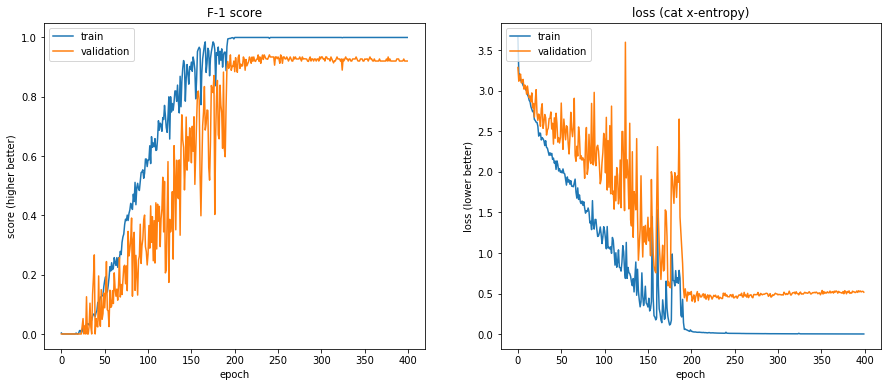

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots (1, 2)

# summarize history for accuracy
axs[0].plot (history.history['fbeta'][:400])
if 'val_fbeta' in history.history:
    axs[0].plot (history.history['val_fbeta'][:400])
axs[0].set (xlabel='epoch', ylabel='score (higher better)', title='F-{} score'.format (PARAM_BETA))
axs[0].legend (['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot (history.history['loss'][:400])
if 'val_loss' in history.history:
    axs[1].plot (history.history['val_loss'][:400])
axs[1].set (xlabel='epoch', ylabel='loss (lower better)', title='loss (cat x-entropy)')
axs[1].legend (['train', 'validation'], loc='upper left')

fig.set_size_inches ((15., 6.), forward=True)
plt.show ()

**discussion**

[2018-09-02]

epoch 205:
- loss: 0.0280
- val_loss: 0.4546
- fbeta: 1.0000
- val_fbeta: 0.9412

_

Above graphs show the F-beta score per epoch with beta = 1 on the left and the *loss per epoch*, calulated by the mean squared error (mse) on the right.

*loss per epoch*:
- gradient steps start with a loss of 0.052, end by 0.042 and show a smooth concave curve. The curve couldn't be better except a faster drop in the first 10 epochs.
- the worse: mse after 1st epoch = 0.052 - the CNN learns very slow and in tiny steps (1st/2nd epoch: 0.052-0.049 = 0.003)

*F-beta score per epoch*
- evaluation metric immediately drops to zero after some epochs - the CNN doesn't learn anything yet

#### reasons / todo

*input data*

(1) The used dataset only has 240 samples for training, validation and test. This is by far nothing for the CNN.

Todo: retrieve more samples for the dataset

(2) A quick look at random spectrograms show kind of chaotic information - as a human being it is hard to tell if there's any structure behind each key-mode pair. This may apply to the CNN too.

Todo: find additional filter techniques / methods to clearly bring out structures for the CNN

(3) Songs can change in key over their whole length.

Todo: take appropriate sample of a song - ommit bridges, refrains, silent passages, noisy songs

_

*model training*

The model was trained for 100 epochs, each in batches of 10 samples per feedfwd-backprop step. To make sure that the architecture is well suited, more epochs shall be run.

Todo: increase epochs, change batch size

_

*model architecture*

Todo: To better understand the insight of the CNN, visualize the filter of the convolutions. May there be enlightenment what kind of architecture works best.

#### compare learning algorithm to benchmarks

[i] below statements can be run without executing the whole notebook

Therefor, go to and execute <a href='#load-learning-algorithm'>load learning algorithm</a>

**TODO** **TODO** **TODO**

In [124]:
score = model.evaluate (X_test, y_test, verbose=1)
print ([(model.metrics_names[i], score[i]) for i in range (len (model.metrics_names))])

174/174 [==============================] - 3s 17ms/step
[('loss', 0.005754849627271466), ('fbeta', 0.935651016646418)]


In [133]:
prediction = model.predict (X_test[np.newaxis, 0])
print (prediction.max (), prediction.argmax ())

0.8309754 21


## Misc
---

### save learning algorithm

In [51]:
# serialization of model architecture
import os

save_name = os.path.join ('model', 'model.arch.yaml')

print ('>>> saving model...', end=' ', flush=True)
yaml_string = model.to_yaml ()
with open (save_name, 'w') as yaml_file:
    yaml_file.write (yaml_string)
print ('done')

>>> saving model... done


### save history

In [150]:
import os
import pandas as pd

print ('>>> saving history...', end=' ', flush=True)
hist_df = pd.DataFrame.from_dict (history.history)
hist_df.to_csv (os.path.join ('model', 'model.hist_180902.csv'))
print ('done')

>>> saving history... done


### load learning algorithm

In [99]:
# load model architecture
from keras import models

load_name = os.path.join ('model', 'model.arch_180902.yaml')
print ('>>> loading and compiling model...', end=' ', flush=True)
with open (load_name, 'r') as yaml_file:
    yaml_string = yaml_file.read ()
model = models.model_from_yaml (yaml_string)
model.compile (optimizer=opt_sgd, loss=losses.mean_squared_error, metrics=[fbeta])
print ('done')

# load best weights
print ('>>> loading best weights into model...', end=' ', flush=True)
model.load_weights (os.path.join ('model','model.w.best_180902.h5'))
print ('done')

>>> loading and compiling model... done
>>> loading best weights into model... done


In [104]:
idx = 278
test_file = src_spectro_data['filenames'][idx]

test_spectro = path_to_tensor (test_file)
test_pred = model.predict (test_spectro)

print (test_file)
print ('y_true', src_spectro_data['target_names'][src_spectro_data['target'][idx]])
print ('y_pred', src_spectro_data['target_names'][test_pred.argmax ()])

src_spectro/8-0/TRHQWMN128F426AB93.png
y_true 8-0
y_pred 8-0


## Obsolete

**drawbacks** (known, unresolvable issues)

(WRONG) *music keys vs CNN key classes*

See <a href='https://www.researchgate.net/publication/228963946_Audio_onset_detection_using_machine_learning_techniques_the_effect_and_applicability_of_key_and_tempo_information'>Chuan, Ching-Hua & Chew, Elaine. (2018). Audio onset detection using machine learning techniques: the effect and applicability of key and tempo information.</a>, p. 18

The spectrograms show a pitch range given by the <a href='https://en.wikipedia.org/wiki/Scientific_pitch_notation#Table_of_note_frequencies'>Scientific Pitch Notation</a>. By that the range of notes goes from $C_{-1}$ = $0_{MIDI}$ up to $G_9$ = $127_{MIDI}$.

Each note can be the tonic of a music key - for example the key 'C major' exists 11 times (ocatve -1 to 9). Thus the information of 128 keys is now squeezed into 24 key classes.

...